In [1]:
import numpy as np
import pandas as pd
from pybedtools import BedTool
import gzip
from matplotlib import pyplot as plt
import seaborn as sns
from tqdm import tqdm

In [2]:
def norm_exons(fk1, exon, fk2):
    pos_names = [f'bin_{str(i+1)}' for i in range(120)]
    exon_cols = [f'bin_{str(i)}' for i in range(31, 91)]
    snmf_norm_factor = pd.concat([fk1[exon_cols], fk2[exon_cols]], axis=1).mean(axis=1)
    snmf_idx = snmf_norm_factor.loc[snmf_norm_factor >= 0.01].index

    X_fk1 = fk1.loc[snmf_idx, pos_names].T.divide(snmf_norm_factor.loc[snmf_idx]).T
    X = exon.loc[snmf_idx, pos_names].T.divide(snmf_norm_factor.loc[snmf_idx]).T
    X_fk2 = fk2.loc[snmf_idx, pos_names].T.divide(snmf_norm_factor.loc[snmf_idx]).T

    avg_exon = X[exon_cols].mean(axis=1)
    return X_fk1, X, X_fk2, avg_exon

def load_matrices_per_tissue(tissue, annotation, exon_type):
    col_names = ['chrom', 'start', 'end', 'gene', 'score', 'strand']
    pos_names = [f'bin_{str(i+1)}' for i in range(120)]
    
    col_names += pos_names
    fk1 = pd.read_csv(f'../code/CoveragePlots/matrices/cassette_exons/{tissue}.{annotation}.{exon_type}.flanking1.mat.gz', sep='\t', skiprows=1,
                             names=col_names)

    fk2 = pd.read_csv(f'../code/CoveragePlots/matrices/cassette_exons/{tissue}.{annotation}.{exon_type}.flanking2.mat.gz', sep='\t', skiprows=1,
                                 names=col_names)
    
    exon = pd.read_csv(f'../code/CoveragePlots/matrices/cassette_exons/{tissue}.{annotation}.{exon_type}.exon.mat.gz', sep='\t', skiprows=1,
                                 names=col_names)

    return fk1, exon, fk2

def get_stats_per_annotation(tissue_list, annotation, exon_type):
    df_avg_exons = pd.DataFrame()
    matrix_dict = {}
    for tissue in tissue_list:
        fk1, exon, fk2 = load_matrices_per_tissue(tissue, annotation, exon_type)
        X_fk1, X, X_fk2, avg_exon = norm_exons(fk1, exon, fk2)
        df_avg_exons[tissue] = avg_exon
        matrix_dict.update({tissue:{
            'fk1':X_fk1,
            'exon':X,
            'fk2':X_fk2
        }})

    max_tissues = df_avg_exons.idxmax(axis=1)
    min_tissues = df_avg_exons.idxmin(axis=1)
        
    return matrix_dict, df_avg_exons, max_tissues, min_tissues

def plot_cassette_exon(fk1, exon, fk2, ax=None, q = 0.5):
    pos_names = [f'bin_{str(i+1)}' for i in range(120)]
    exon_cols = [f'bin_{str(i)}' for i in range(31, 91)]
    snmf_norm_factor = pd.concat([fk1[exon_cols], fk2[exon_cols]], axis=1).mean(axis=1)
    snmf_idx = snmf_norm_factor.loc[snmf_norm_factor >= 0.01].index

    X_fk1 = fk1.loc[snmf_idx, pos_names].T.divide(snmf_norm_factor.loc[snmf_idx]).T
    X = exon.loc[snmf_idx, pos_names].T.divide(snmf_norm_factor.loc[snmf_idx]).T
    X_fk2 = fk2.loc[snmf_idx, pos_names].T.divide(snmf_norm_factor.loc[snmf_idx]).T

    if ax is None:
        fig, ax = plt.subplots(figsize = (4, 1))

    ax.plot(np.array(X_fk1.quantile(0.5, axis=0)), linewidth = 2, c='black')
    ax.fill_between(np.arange(120)+130, [0]*120, np.array(X.quantile(q, axis=0)), linewidth = 2, color='gray')
    #ax.plot(np.arange(120)+130, np.array(X.quantile(q, axis=0)), linewidth = 2, c='gray')
    ax.plot(np.arange(120)+260, np.array(X_fk2.quantile(0.5, axis=0)), linewidth = 2, c='black')

In [3]:
tissue_list = ['Brain_Anterior_cingulate_cortex_BA24',
'Brain_Frontal_Cortex_BA9',  
'Heart_Atrial_Appendage',
'Lung',
'Skin_Not_Sun_Exposed_Suprapubic',
'Brain_Cortex',                          
'Brain_Putamen_basal_ganglia',  
'Liver',                   
'Muscle_Skeletal',  
'Whole_Blood']

In [4]:
# def plot_annotation_exons(annotation):
    # 

def plot_annotation_tissue(annotation, tissue):
    exon_types = ['cassette_exon', 'exon_only', 'intron_only']
    fig, axes = plt.subplots(nrows = 4, ncols = 3, figsize=(7, 3), gridspec_kw={'wspace':0.1, 'height_ratios': [1, 1, 1, 0.3]})

    for i, exon_type in enumerate(exon_types):
        plot_annotation_tissue_exons_type(annotation, exon_type, tissue, axes, i)

    for i in range(3):
        axes[3, i].plot([0, 120], [0.5, 0.5], c='black', zorder=1, linewidth = 3)
        axes[3, i].plot([130, 250], [0.5, 0.5], c='gray', zorder=1, linewidth = 3)
        axes[3, i].plot([260, 380], [0.5, 0.5], c='black', zorder=1, linewidth = 3)
        axes[3, i].plot([120, 130], [0.25, 0.75], c='red', zorder=1, linewidth=2)
        axes[3, i].plot([250, 260], [0.25, 0.75], c='red', zorder=1, linewidth=2)
        axes[3, i].fill_between(np.arange(30, 90), [0]*60, [1]*60, color='black', zorder=2)
        axes[3, i].fill_between(np.arange(30, 90)+130, [0]*60, [1]*60, color='gray', zorder=2)
        axes[3, i].fill_between(np.arange(30, 90)+260, [0]*60, [1]*60, color='black', zorder=2)
        axes[3, i].set_xticks([])
        axes[3, i].set_yticks([])
        axes[3, i].spines['top'].set_visible(False)
        axes[3, i].spines['right'].set_visible(False)
        axes[3, i].spines['bottom'].set_visible(False)
        axes[3, i].spines['left'].set_visible(False)

        for j in range(3):
            if i > 0:
                axes[j, i].set_yticks([])
        
            axes[j, i].set_ylim([-0.1, 1.2])
            axes[j, i].set_xticks([])
            axes[j, i].spines['top'].set_visible(False)
            axes[j, i].spines['right'].set_visible(False)

    axes[0, 0].set_ylabel('cassette')
    axes[1, 0].set_ylabel('constitutive')
    axes[2, 0].set_ylabel('skipped')

    axes[0, 0].set_title('Quartile 1')
    axes[0, 1].set_title('Quartile 2')
    axes[0, 2].set_title('Quartile 3')


def plot_annotation_tissue_exons_type(annotation, exon_type, tissue, axes, i):
    # matrix_dict, df_avg_exons, max_tissues, min_tissues = get_stats_per_annotation(tissue_list, annotation, exon_type)
    fk1, exon, fk2 = load_matrices_per_tissue(tissue, annotation, exon_type)
    X_fk1, X, X_fk2, avg_exon = norm_exons(fk1, exon, fk2)
    plot_cassette_exon(X_fk1, X, X_fk2, axes[i, 0], 0.25)
    plot_cassette_exon(X_fk1, X, X_fk2, axes[i, 1], 0.5)
    plot_cassette_exon(X_fk1, X, X_fk2, axes[i, 2], 0.75)

def plot_annotation_exons_type(annotation, exon_type, axes, i):
        
    matrix_dict, df_avg_exons, max_tissues, min_tissues = get_stats_per_annotation(tissue_list, annotation, exon_type)

    exon_min = pd.concat([matrix_dict[tissue]['exon'].loc[min_tissues.loc[min_tissues == tissue].index] for tissue in tissue_list], axis=0)
    fk1_min = pd.concat([matrix_dict[tissue]['fk1'].loc[min_tissues.loc[min_tissues == tissue].index] for tissue in tissue_list], axis=0)
    fk2_min = pd.concat([matrix_dict[tissue]['fk2'].loc[min_tissues.loc[min_tissues == tissue].index] for tissue in tissue_list], axis=0)
    
    exon_tissue = matrix_dict['Liver']['exon']
    fk1_tissue = matrix_dict['Liver']['fk1']
    fk2_tissue = matrix_dict['Liver']['fk2']
    
    exon_max = pd.concat([matrix_dict[tissue]['exon'].loc[max_tissues.loc[max_tissues == tissue].index] for tissue in tissue_list], axis=0)
    fk1_max = pd.concat([matrix_dict[tissue]['fk1'].loc[max_tissues.loc[max_tissues == tissue].index] for tissue in tissue_list], axis=0)
    fk2_max = pd.concat([matrix_dict[tissue]['fk2'].loc[max_tissues.loc[max_tissues == tissue].index] for tissue in tissue_list], axis=0)
    
    plot_cassette_exon(fk1_min, exon_min, fk2_min, axes[i, 0], 0.25)
    plot_cassette_exon(fk1_min, exon_min, fk2_min, axes[i, 1], 0.5)
    plot_cassette_exon(fk1_tissue, exon_tissue, fk2_tissue, axes[i, 2], 0.5)
    plot_cassette_exon(fk1_max, exon_max, fk2_max, axes[i, 3], 0.5)

    
    # plot_cassette_exon(fk1_max, exon_max, fk2_max, axes[i, 4], 0.75)

def plot_annotation_exons(annotation):
    exon_types = ['cassette_exon', 'exon_only', 'intron_only']
    fig, axes = plt.subplots(nrows = 4, ncols = 4, figsize=(5, 2.5), gridspec_kw={'wspace':0.1, 'height_ratios': [1, 1, 1, 0.3]})

    for i, exon_type in enumerate(exon_types):
        plot_annotation_exons_type(annotation, exon_type, axes, i)

    for i in range(4):
        axes[3, i].plot([0, 120], [0.5, 0.5], c='black', zorder=1, linewidth = 3)
        axes[3, i].plot([130, 250], [0.5, 0.5], c='gray', zorder=1, linewidth = 3)
        axes[3, i].plot([260, 380], [0.5, 0.5], c='black', zorder=1, linewidth = 3)
        axes[3, i].plot([120, 130], [0.25, 0.75], c='red', zorder=1, linewidth=2)
        axes[3, i].plot([250, 260], [0.25, 0.75], c='red', zorder=1, linewidth=2)
        axes[3, i].fill_between(np.arange(30, 90), [0]*60, [1]*60, color='black', zorder=2)
        axes[3, i].fill_between(np.arange(30, 90)+130, [0]*60, [1]*60, color='gray', zorder=2)
        axes[3, i].fill_between(np.arange(30, 90)+260, [0]*60, [1]*60, color='black', zorder=2)
        axes[3, i].set_xticks([])
        axes[3, i].set_yticks([])
        axes[3, i].spines['top'].set_visible(False)
        axes[3, i].spines['right'].set_visible(False)
        axes[3, i].spines['bottom'].set_visible(False)
        axes[3, i].spines['left'].set_visible(False)

        for j in range(3):
            if i > 0:
                axes[j, i].set_yticks([])
        
            axes[j, i].set_ylim([-0.1, 1.2])
            axes[j, i].set_xticks([])
            axes[j, i].spines['top'].set_visible(False)
            axes[j, i].spines['right'].set_visible(False)


    axes[0, 0].set_ylabel('cassette')
    axes[1, 0].set_ylabel('constitutive')
    axes[2, 0].set_ylabel('skipped')

    axes[0, 0].set_title('Lowest tissue\n(bottom decile)')
    axes[0, 1].set_title('Lowest tissue\n(median)')
    axes[0, 2].set_title('Liver tissue\n(median)')
    axes[0, 3].set_title('Highest tissue\n(median)')


In [7]:
def plot_tissue_quintiles_exon_type(tissue, annotation, exon_type, i, axes=None):

    fk1, exon, fk2 = load_matrices_per_tissue(tissue, annotation, exon_type)
    X_fk1, X, X_fk2, avg_exon = norm_exons(fk1, exon, fk2)
    
    pos_names = [f'bin_{str(i+1)}' for i in range(120)]
    exon_cols = [f'bin_{str(i)}' for i in range(31, 91)]
    mean_exon_coverage = X[exon_cols].mean(axis=1)
    mean_exon_coverage_ = mean_exon_coverage.loc[mean_exon_coverage <= 1.25]
    
    Q5 = mean_exon_coverage_.loc[mean_exon_coverage_ >= mean_exon_coverage_.quantile(0.8)].index
    Q4 = mean_exon_coverage_.loc[
        (mean_exon_coverage_ <= mean_exon_coverage_.quantile(0.8)) & (mean_exon_coverage_ >= mean_exon_coverage_.quantile(0.6))
    ].index
    Q3 = mean_exon_coverage_.loc[
        (mean_exon_coverage_ <= mean_exon_coverage_.quantile(0.6)) & (mean_exon_coverage_ >= mean_exon_coverage_.quantile(0.4))
    ].index
    Q2 = mean_exon_coverage_.loc[
        (mean_exon_coverage_ <= mean_exon_coverage_.quantile(0.4)) & (mean_exon_coverage_ >= mean_exon_coverage_.quantile(0.2))
    ].index
    Q1 = mean_exon_coverage_.loc[mean_exon_coverage_ <= mean_exon_coverage_.quantile(0.2)].index

    # if axes is None:
    #     fig, axes = plt.subplots(ncols = 5, figsize=(2, 5))

    plot_cassette_exon(X_fk1.loc[Q1], X.loc[Q1], X_fk2.loc[Q1], axes[i, 0], 0.5)
    plot_cassette_exon(X_fk1.loc[Q2], X.loc[Q2], X_fk2.loc[Q2], axes[i, 1], 0.5)
    plot_cassette_exon(X_fk1.loc[Q3], X.loc[Q3], X_fk2.loc[Q3], axes[i, 2], 0.5)
    plot_cassette_exon(X_fk1.loc[Q4], X.loc[Q4], X_fk2.loc[Q4], axes[i, 3], 0.5)
    plot_cassette_exon(X_fk1.loc[Q5], X.loc[Q5], X_fk2.loc[Q5], axes[i, 4], 0.5)


def plot_tissue_quintiles_annotation(tissue, annotation, annot_name = 'Gencode', annot_color = 'tab:orange', labels = ['x', 'y', 'z']):
    x, y, z = [str(a) for a in labels]
    exon_types = ['cassette_exon', 'exon_only', 'intron_only']
    fig, axes = plt.subplots(nrows = 4, ncols = 7, figsize=(10, 3), gridspec_kw={'wspace':0.1, 'height_ratios': [1, 1, 1, 0.3]})

    for i, exon_type in enumerate(exon_types):
        plot_tissue_quintiles_exon_type(tissue, annotation, exon_type, i, axes)


    for i in range(5):
        axes[3, i].plot([0, 120], [0.5, 0.5], c='black', zorder=1, linewidth = 3)
        axes[3, i].plot([130, 250], [0.5, 0.5], c='gray', zorder=1, linewidth = 3)
        axes[3, i].plot([260, 380], [0.5, 0.5], c='black', zorder=1, linewidth = 3)
        axes[3, i].plot([120, 130], [0.25, 0.75], c='red', zorder=1, linewidth=2)
        axes[3, i].plot([250, 260], [0.25, 0.75], c='red', zorder=1, linewidth=2)
        axes[3, i].fill_between(np.arange(30, 90), [0]*60, [1]*60, color='black', zorder=2)
        axes[3, i].fill_between(np.arange(30, 90)+130, [0]*60, [1]*60, color='gray', zorder=2)
        axes[3, i].fill_between(np.arange(30, 90)+260, [0]*60, [1]*60, color='black', zorder=2)
        axes[3, i].set_xticks([])
        axes[3, i].set_yticks([])
        axes[3, i].spines['top'].set_visible(False)
        axes[3, i].spines['right'].set_visible(False)
        axes[3, i].spines['bottom'].set_visible(False)
        axes[3, i].spines['left'].set_visible(False)

        for j in range(3):
            if i > 0:
                axes[j, i].set_yticks([])
        
            axes[j, i].set_ylim([-0.1, 1.2])
            axes[j, i].set_xticks([])
            axes[j, i].spines['top'].set_visible(False)
            axes[j, i].spines['right'].set_visible(False)

    axes[0, 0].set_ylabel('PSI')
    axes[1, 0].set_ylabel('PSI')
    axes[2, 0].set_ylabel('PSI')

    axes[0, 0].set_title('Q1')
    axes[0, 1].set_title('Q2')
    axes[0, 2].set_title('Q3')
    axes[0, 3].set_title('Q4')
    axes[0, 4].set_title('Q5')

    for j in range(3):
        axes[j, 5].set_ylim([-3, 4])
        axes[j, 6].set_ylim([-3, 4])
        if j in [0, 1]:
            a = 1
        else:
            a = 0.1
        axes[j, 5].plot([0, 380], [0.5, 0.5], c='tab:blue', linewidth=3, alpha=a)
        axes[j, 5].fill_between(np.arange(30, 90), [0]*60, [1]*60, color='tab:blue', zorder=2, alpha=a)
        axes[j, 5].fill_between(np.arange(30, 90)+130, [0]*60, [1]*60, color='tab:blue', zorder=2, alpha=a)
        axes[j, 5].fill_between(np.arange(30, 90)+260, [0]*60, [1]*60, color='tab:blue', zorder=2, alpha=a)

        if j in [0, 2]:
            a = 1
        else:
            a = 0.1
        axes[j, 5].plot([0, 380], [2.5, 2.5], c='tab:blue', linewidth=3, alpha=a)
        axes[j, 5].fill_between(np.arange(30, 90), [2]*60, [3]*60, color='tab:blue', zorder=2, alpha=a)
        # axes[j, 5].fill_between(np.arange(30, 90)+130, [2]*60, [3]*60, color='black', zorder=2)
        axes[j, 5].fill_between(np.arange(30, 90)+260, [2]*60, [3]*60, color='tab:blue', zorder=2, alpha=a)

        axes[j, 6].plot([0, 380], [0.5, 0.5], c=annot_color, linewidth=3)
        axes[j, 6].fill_between(np.arange(30, 90), [0]*60, [1]*60, color=annot_color, zorder=2)
        axes[j, 6].fill_between(np.arange(30, 90)+130, [0]*60, [1]*60, color=annot_color, zorder=2)
        axes[j, 6].fill_between(np.arange(30, 90)+260, [0]*60, [1]*60, color=annot_color, zorder=2)

        axes[j, 6].plot([0, 380], [2.5, 2.5], c=annot_color, linewidth=3)
        axes[j, 6].fill_between(np.arange(30, 90), [2]*60, [3]*60, color=annot_color, zorder=2)
        # axes[j, 6].fill_between(np.arange(30, 90)+130, [2]*60, [3]*60, color='tab:orange', zorder=2)
        axes[j, 6].fill_between(np.arange(30, 90)+260, [2]*60, [3]*60, color=annot_color, zorder=2)

    for j in range(4):
        for i in range(5, 7):
            axes[j, i].set_xticks([])
            axes[j, i].set_yticks([])
            axes[j, i].spines['top'].set_visible(False)
            axes[j, i].spines['right'].set_visible(False)
            axes[j, i].spines['bottom'].set_visible(False)
            axes[j, i].spines['left'].set_visible(False)

    axes[0, 5].set_title('Torino', c='tab:blue')
    axes[0, 6].set_title(annot_name, c=annot_color)

    axes[0, 6].text(100, -2, f'({x})', c=annot_color)
    axes[1, 6].text(100, -2, f'({y})', c=annot_color)
    axes[2, 6].text(100, -2, f'({z})', c=annot_color)

In [8]:
4088-3802

286

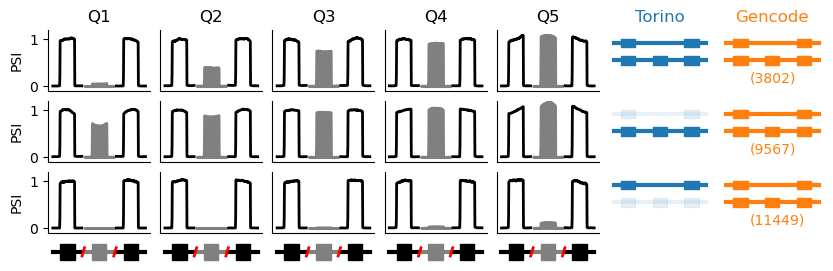

In [9]:
plot_tissue_quintiles_annotation('Whole_Blood', 'gencode', labels = [3802, 9567, 11449])
plt.savefig('../code/scratch_figures/figure2/cassette_exons.gencode.pdf', bbox_inches='tight')
plt.savefig('../code/scratch_figures/figure2/cassette_exons.gencode.png', bbox_inches='tight', dpi=500)

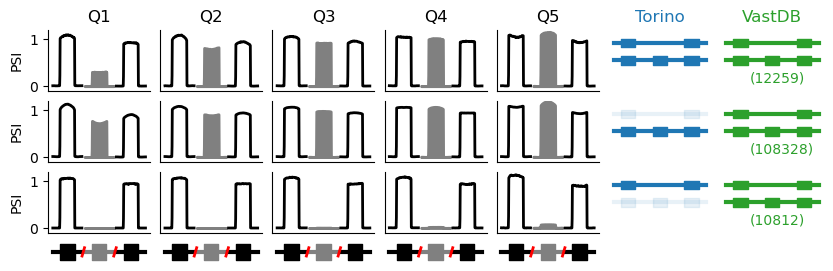

In [10]:
plot_tissue_quintiles_annotation('Whole_Blood', 'vastdb', annot_name = 'VastDB', annot_color = 'tab:green', 
                                 labels = [12259, 108328, 10812])
plt.savefig('../code/scratch_figures/figure2/cassette_exons.vastdb.pdf', bbox_inches='tight')
plt.savefig('../code/scratch_figures/figure2/cassette_exons.vastdb.png', bbox_inches='tight', dpi=500)

In [8]:
snmf_cassette_exons = pd.read_csv('../code/ebpmf_models/filtered/snmf_10/tables/cassette_exons.bed.gz', sep='\t')

gencode_exons_file = '/project2/mstephens/cfbuenabadn/gtex-stm/code/Annotations/gencode.v44.primary_assembly.exons.sorted.bed.gz'
gencode_exons_df = pd.read_csv(gencode_exons_file, sep='\t', 
                            names = ['chrom', 'start', 'end', 'gene_id', 
                                                           'transcript_id', 'strand', 'exon_id', 'transcript_support_level',
                                                           'basic', 'Ensembl_canonical', 'MANE_Select', 'appris', 'transcript_type'])

gencode_exons_bed = BedTool.from_dataframe(gencode_exons_df)


vastdb_exons_df = pd.read_csv('/project2/yangili1/cfbuenabadn/CSQ_additional_files/EVENT_INFO-hg38.tab.gz', sep='\t')
vastdb_exons_df = vastdb_exons_df.dropna()
vastdb_exons_cols = list(vastdb_exons_df.columns)
vastdb_exons_df['chrom'] = vastdb_exons_df.CO_A.apply(lambda x: x.split(':')[0])
vastdb_exons_df['start'] = vastdb_exons_df.CO_A.apply(lambda x: x.split(':')[1].split('-')[0])
vastdb_exons_df['end'] = vastdb_exons_df.CO_A.apply(lambda x: x.split('-')[1])
vastdb_exons_cols = ['chrom', 'start', 'end'] + vastdb_exons_cols
vastdb_exons_df = vastdb_exons_df[vastdb_exons_cols]

vastdb_exons_df = vastdb_exons_df.loc[(~vastdb_exons_df.COMPLEX.isin(['MIC-S', 'MIC_S', 'IR', 'Alt3', 'Alt5', 'MIC-M'])) & (vastdb_exons_df.EVENT.apply(lambda x: x.startswith('HsaEX')))]
vastdb_exons_df = vastdb_exons_df.loc[(~ vastdb_exons_df.COMPLEX.apply(lambda x: (x.startswith('ME') or (x == 'A_NA') or (x == 'ANN') or x == 'NA*')))]
vastdb_exons_df = vastdb_exons_df[[x for x in vastdb_exons_df.columns if x not in ['Seq_C1', 'Seq_A', 'Seq_C2']]]
vastdb_exons_df['strand'] = vastdb_exons_df.REF_CO.apply(lambda x: x.split(':')[-1])

intron_start_list = []
intron_end_list = []
for idx, row in vastdb_exons_df.iterrows():
    strand = row.strand
    if strand == '+':
        intron_start = int(row.CO_C1.split('-')[-1])
        intron_end = int(row.CO_C2.split('-')[0].split(':')[1])
    else:
        intron_start = int(row.CO_C2.split('-')[-1])
        intron_end = int(row.CO_C1.split('-')[0].split(':')[1])
        
    intron_start_list.append(intron_start)
    intron_end_list.append(intron_end)

vastdb_introns_df = pd.DataFrame()
vastdb_introns_df['chrom'] = list(vastdb_exons_df.chrom)
vastdb_introns_df['start'] = intron_start_list
vastdb_introns_df['end'] = intron_end_list
vastdb_introns_df['GENE'] = list(vastdb_exons_df.GENE)
vastdb_introns_df['EVENT'] = list(vastdb_exons_df.EVENT)
vastdb_introns_df['strand'] = list(vastdb_exons_df.strand)

vastdb_introns_bed = BedTool.from_dataframe(vastdb_introns_df).sort()
vastdb_exons_bed = BedTool.from_dataframe(vastdb_exons_df).sort()


# snmf_cassette_exons = pd.read_csv('../code/ebpmf_models/filtered/snmf_10/tables/cassette_exons.bed.gz', sep='\t')
snmf_cassette_exons_bed = BedTool.from_dataframe(snmf_cassette_exons)

snmf_vastdb_cassette_exons = snmf_cassette_exons_bed.intersect(vastdb_exons_bed, f=1, F=1, wo=True).to_dataframe(
    names = list(snmf_cassette_exons.columns) + [f'{x}_vastdb' for x in vastdb_exons_df.columns] + ['overlaps']
)


intron_start_vastdb = []
intron_end_vastdb = []
for idx, row in snmf_vastdb_cassette_exons.iterrows():
    if row.strand_vastdb == '+':
        intron_start = row.CO_C1_vastdb
        intron_end = row.CO_C2_vastdb
    else:
        intron_start = row.CO_C2_vastdb
        intron_end = row.CO_C1_vastdb
    intron_start = int(intron_start.split('-')[-1])
    intron_end = int(intron_end.split(':')[-1].split('-')[0])

    intron_start_vastdb.append(intron_start)
    intron_end_vastdb.append(intron_end)

snmf_vastdb_cassette_exons['intron_start_vastdb'] = intron_start_vastdb
snmf_vastdb_cassette_exons['intron_end_vastdb'] = intron_end_vastdb

snmf_vastdb_cassette_exons_confirmed = snmf_vastdb_cassette_exons.loc[
(snmf_vastdb_cassette_exons.intron_start == snmf_vastdb_cassette_exons.intron_start_vastdb) & (snmf_vastdb_cassette_exons.intron_end == snmf_vastdb_cassette_exons.intron_end_vastdb)
]


snmf_vastdb_cassette_exons_confirmed['annot'] = snmf_vastdb_cassette_exons_confirmed[
['chrom', 'start', 'end', 'intron_start', 'intron_end']].astype(str).agg(':'.join, axis=1)

def load_matrices_per_tissue(tissue, annotation, exon_type):
    col_names = ['chrom', 'start', 'end', 'gene', 'score', 'strand']
    pos_names = [f'bin_{str(i+1)}' for i in range(120)]
    
    col_names += pos_names
    fk1 = pd.read_csv(f'../code/CoveragePlots/matrices/cassette_exons/{tissue}.{annotation}.{exon_type}.flanking1.mat.gz', sep='\t', skiprows=1,
                             names=col_names)

    fk2 = pd.read_csv(f'../code/CoveragePlots/matrices/cassette_exons/{tissue}.{annotation}.{exon_type}.flanking2.mat.gz', sep='\t', skiprows=1,
                                 names=col_names)
    
    exon = pd.read_csv(f'../code/CoveragePlots/matrices/cassette_exons/{tissue}.{annotation}.{exon_type}.exon.mat.gz', sep='\t', skiprows=1,
                                 names=col_names)

    return fk1, exon, fk2
    
snmf_cassette_exons = pd.read_csv('../code/ebpmf_models/filtered/snmf_10/tables/cassette_exons.bed.gz', sep='\t')


col_names = ['chrom', 'start', 'end', 'gene', 'score', 'strand']
pos_names = [f'bin_{str(i+1)}' for i in range(120)]
gencode_snmf_cassette_exons = pd.read_csv('../code/CoveragePlots/bed_files/cassette_exons/gencode/cassette_exon.exon.bed', 
                                          sep='\t', names = ['chrom', 'start', 'end', 'name', 'transcripts'])


snmf_gencode_cassette_exons = pd.read_csv('../code/CoveragePlots/bed_files/cassette_exons/snmf/gencode.exon.bed',
                                          sep='\t', names = ['chrom', 'start', 'end', 'name', 'transcripts'])

snmf_gencode_fk1 = pd.read_csv('../code/CoveragePlots/bed_files/cassette_exons/snmf/gencode.flanking1.bed',
                                          sep='\t', names = ['chrom', 'start', 'end', 'name', 'transcripts'])
snmf_gencode_fk2 = pd.read_csv('../code/CoveragePlots/bed_files/cassette_exons/snmf/gencode.flanking2.bed',
                                          sep='\t', names = ['chrom', 'start', 'end', 'name', 'transcripts'])

fk1, exon, fk2 = load_matrices_per_tissue('Liver', 'gencode', 'cassette_exon')
gencode_exon = exon[['chrom', 'start', 'end']].copy()
gencode_exon['intron_start'] = fk1.end
gencode_exon['intron_end'] = fk2.start

gencode_exon['annot'] = gencode_exon.chrom + ':' + gencode_exon.start.astype(str) + ':' + gencode_exon.end.astype(str) + ':'+ gencode_exon.intron_start.astype(str) + ':' + gencode_exon.intron_end.astype(str) 

snmf_exon = snmf_gencode_cassette_exons[['chrom', 'start', 'end']].copy()
snmf_exon['intron_start'] = snmf_gencode_fk1.end
snmf_exon['intron_end'] = snmf_gencode_fk2.start

snmf_exon['annot'] = snmf_exon.chrom + ':' + snmf_exon.start.astype(str) + ':' + snmf_exon.end.astype(str) + ':' + snmf_exon.intron_start.astype(str) + ':' + snmf_exon.intron_end.astype(str) 

snmf_gencode_exons = snmf_cassette_exons_bed.intersect(gencode_exons_bed, f=1, F=1, u=True).to_dataframe(names = snmf_cassette_exons.columns)
snmf_vastdb_exons = snmf_cassette_exons_bed.intersect(vastdb_exons_bed, f=1, F=1, u=True).to_dataframe(names = snmf_cassette_exons.columns)

snmf_vastdb_exons['annot'] = snmf_vastdb_exons[
['chrom', 'start', 'end', 'intron_start', 'intron_end']].astype(str).agg(':'.join, axis=1)

snmf_gencode_exons['annot'] = snmf_gencode_exons[
['chrom', 'start', 'end', 'intron_start', 'intron_end']].astype(str).agg(':'.join, axis=1)

# snmf_junctions_cassette_exons

snmf_cassette_exons['annot'] =  snmf_cassette_exons[
['chrom', 'start', 'end', 'intron_start', 'intron_end']].astype(str).agg(':'.join, axis=1)

exons_by_both = pd.Index(snmf_cassette_exons.loc[snmf_cassette_exons.annot.isin(pd.Index(
    snmf_vastdb_cassette_exons_confirmed.annot).intersection(pd.Index(gencode_exon.annot).intersection(pd.Index(snmf_exon.annot))))].transcripts)


snmf_gencode_cassette_exons = pd.read_csv('../code/CoveragePlots/bed_files/cassette_exons/snmf/gencode.exon.bed',
                                          sep='\t', names = ['chrom', 'start', 'end', 'name', 'transcripts'])

snmf_vastdb_cassette_exons = pd.read_csv('../code/CoveragePlots/bed_files/cassette_exons/snmf/vastdb.exon.bed',
                                          sep='\t', names = ['chrom', 'start', 'end', 'name', 'transcripts'])

snmf_junctions_cassette_exons = pd.read_csv('../code/CoveragePlots/bed_files/cassette_exons/snmf/junctions.exon.bed',
                                          sep='\t', names = ['chrom', 'start', 'end', 'name', 'transcripts'])



transcripts_annotated = pd.Index(snmf_gencode_exons.transcripts).union(pd.Index(snmf_vastdb_exons.transcripts)).union(
    pd.Index(snmf_junctions_cassette_exons.transcripts).unique()
)



gencode_exons_file = '/project2/mstephens/cfbuenabadn/gtex-stm/code/Annotations/gencode.v44.primary_assembly.exons.bed.gz'
gencode_exons = pd.read_csv(gencode_exons_file, sep='\t')
gencode_exons_bed = BedTool.from_dataframe(gencode_exons)

# snmf_exons_bed = '/project2/mstephens/cfbuenabadn/gtex-stm/code/ebpmf_models/filtered/snmf_10/tables/snmf.merged_isoforms.exons.sorted.bed.gz'
# snmf_exons = pd.read_csv(snmf_exons_bed, sep='\t', names = ['chrom', 'start', 'end', 'gene_id', 
#                                                  'transcript_id', 'strand', 'factors', 'exon_id'])

bad_exons = snmf_cassette_exons.loc[~snmf_cassette_exons.transcripts.isin(transcripts_annotated)]
bad_exons_bed = BedTool.from_dataframe(bad_exons)

bad_overlap = bad_exons_bed.intersect(gencode_exons_bed, wo=True).to_dataframe(
    names = list(bad_exons.columns) + [f'{x}_gencode' for x in gencode_exons.columns] + ['overlap'])#.shape

bad_no_overlap = bad_exons_bed.intersect(gencode_exons_bed, v=True).to_dataframe(
    names = list(bad_exons.columns))#.shape



transcripts_annotated = pd.Index(snmf_gencode_exons.transcripts).union(pd.Index(snmf_vastdb_exons.transcripts)).union(
    pd.Index(snmf_junctions_cassette_exons.transcripts).union(pd.Index(bad_overlap.transcripts)).unique()
)

/tmp/jobs/41557464/ipykernel_50988/1545460890.py:83: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  snmf_vastdb_cassette_exons_confirmed['annot'] = snmf_vastdb_cassette_exons_confirmed[


In [9]:
annot_by_both = pd.Index(gencode_exon.annot).intersection(pd.Index(snmf_exon.annot)).intersection(pd.Index(snmf_vastdb_cassette_exons_confirmed.annot))
annot_by_any = pd.Index(gencode_exon.annot).intersection(pd.Index(snmf_exon.annot)).union(pd.Index(snmf_vastdb_cassette_exons_confirmed.annot))

annot_by_one = annot_by_any.difference(annot_by_both)

transcripts_annotated = pd.Index(snmf_gencode_exons.transcripts).union(pd.Index(snmf_vastdb_exons.transcripts)).union(
    pd.Index(snmf_junctions_cassette_exons.transcripts)
)

is_exon = pd.Index(snmf_cassette_exons.loc[snmf_cassette_exons.transcripts.isin(transcripts_annotated)].annot.unique())
is_exon_only = is_exon.difference(annot_by_any)

overlap_with_exon = pd.Index(bad_overlap.annot.unique())

no_overlap = pd.Index(bad_no_overlap.annot.unique())


transcripts_by_both = snmf_cassette_exons.loc[snmf_cassette_exons.annot.isin(annot_by_both)].transcripts.unique()
transcripts_by_one = snmf_cassette_exons.loc[snmf_cassette_exons.annot.isin(annot_by_one)].transcripts.unique()
transcripts_exon_only = snmf_cassette_exons.loc[snmf_cassette_exons.annot.isin(is_exon_only)].transcripts.unique()
transcripts_overlap = snmf_cassette_exons.loc[snmf_cassette_exons.annot.isin(overlap_with_exon)].transcripts.unique()
transcripts_no_overlap = snmf_cassette_exons.loc[snmf_cassette_exons.annot.isin(no_overlap)].transcripts.unique()

In [47]:
# plot_tissue_quintiles_annotation('Whole_Blood', 'gencode', labels = [3802, 9567, 11449])
# plt.savefig('../code/scratch_figures/figure2/cassette_exons.gencode.pdf', bbox_inches='tight')
# plt.savefig('../code/scratch_figures/figure2/cassette_exons.gencode.png', bbox_inches='tight', dpi=500)

In [75]:
col_names = ['chrom', 'start', 'end', 'gene', 'score', 'strand']
pos_names = [f'bin_{str(i+1)}' for i in range(120)]
X0 = pd.read_csv('../code/CoveragePlots/matrices/cassette_exons/Liver.snmf.gencode.exon.mat.gz', sep='\t', skiprows=1,
               names = col_names + pos_names)

Y0 = pd.read_csv('../code/CoveragePlots/matrices/cassette_exons/Liver.snmf.gencode.flanking1.mat.gz', sep='\t', skiprows=1,
               names = col_names + pos_names)

Z0 = pd.read_csv('../code/CoveragePlots/matrices/cassette_exons/Liver.snmf.gencode.flanking2.mat.gz', sep='\t', skiprows=1,
               names = col_names + pos_names)

X1 = pd.read_csv('../code/CoveragePlots/matrices/cassette_exons/Liver.snmf.vastdb.exon.mat.gz', sep='\t', skiprows=1,
               names = col_names + pos_names)

Y1 = pd.read_csv('../code/CoveragePlots/matrices/cassette_exons/Liver.snmf.vastdb.flanking1.mat.gz', sep='\t', skiprows=1,
               names = col_names + pos_names)

Z1 = pd.read_csv('../code/CoveragePlots/matrices/cassette_exons/Liver.snmf.vastdb.flanking2.mat.gz', sep='\t', skiprows=1,
               names = col_names + pos_names)

X2 = pd.read_csv('../code/CoveragePlots/matrices/cassette_exons/Liver.snmf.junctions.exon.mat.gz', sep='\t', skiprows=1,
               names = col_names + pos_names)

Y2 = pd.read_csv('../code/CoveragePlots/matrices/cassette_exons/Liver.snmf.junctions.flanking1.mat.gz', sep='\t', skiprows=1,
               names = col_names + pos_names)

Z2 = pd.read_csv('../code/CoveragePlots/matrices/cassette_exons/Liver.snmf.junctions.flanking2.mat.gz', sep='\t', skiprows=1,
               names = col_names + pos_names)


X3 = pd.read_csv('../code/CoveragePlots/matrices/cassette_exons/Liver.snmf.unmatched.exon.mat.gz', sep='\t', skiprows=1,
               names = col_names + pos_names)

Y3 = pd.read_csv('../code/CoveragePlots/matrices/cassette_exons/Liver.snmf.unmatched.flanking1.mat.gz', sep='\t', skiprows=1,
               names = col_names + pos_names)

Z3 = pd.read_csv('../code/CoveragePlots/matrices/cassette_exons/Liver.snmf.unmatched.flanking2.mat.gz', sep='\t', skiprows=1,
               names = col_names + pos_names)

In [104]:
X = pd.concat([X0, X1, X2, X3], axis=0).reset_index(drop=True)
Y = pd.concat([Y0, Y1, Y2, Y3], axis=0).reset_index(drop=True)
Z = pd.concat([Z0, Z1, Z2, Z3], axis=0).reset_index(drop=True)

In [105]:
annot_ = X[['chrom', 'start', 'end']].astype(str).agg(':'.join, axis=1) + ':' + Y.end.astype(str) + ':' + Z.start.astype(str)
annot_whole = X[['chrom', 'start', 'end']].astype(str).agg(':'.join, axis=1) + ':' + Y.end.astype(str) + ':' + Z.start.astype(str) + ':' + Y.start.astype(str) + ':' + Z.end.astype(str)

X['annot'] = annot_
Y['annot'] = annot_
Z['annot'] = annot_


X['annot_whole'] = annot_whole
Y['annot_whole'] = annot_whole
Z['annot_whole'] = annot_whole

In [108]:
X = X.loc[X.drop_duplicates().index]
Y = Y.loc[X.drop_duplicates().index]
Z = Z.loc[X.drop_duplicates().index]

In [44]:
def plot_tissue_quintiles_for_snmf(fk1, exon, fk2, annotation, exon_type, i, axes=None):

    # fk1, exon, fk2 = load_matrices_per_tissue(tissue, annotation, exon_type)
    X_fk1, X, X_fk2, avg_exon = norm_exons(fk1, exon, fk2)

    
    pos_names = [f'bin_{str(i+1)}' for i in range(120)]
    exon_cols = [f'bin_{str(i)}' for i in range(31, 91)]
    mean_exon_coverage = X[exon_cols].mean(axis=1)
    mean_exon_coverage_ = mean_exon_coverage.loc[mean_exon_coverage <= 1.25]
    
    Q5 = mean_exon_coverage_.loc[mean_exon_coverage_ >= mean_exon_coverage_.quantile(0.8)].index
    Q4 = mean_exon_coverage_.loc[
        (mean_exon_coverage_ <= mean_exon_coverage_.quantile(0.8)) & (mean_exon_coverage_ >= mean_exon_coverage_.quantile(0.6))
    ].index
    Q3 = mean_exon_coverage_.loc[
        (mean_exon_coverage_ <= mean_exon_coverage_.quantile(0.6)) & (mean_exon_coverage_ >= mean_exon_coverage_.quantile(0.4))
    ].index
    Q2 = mean_exon_coverage_.loc[
        (mean_exon_coverage_ <= mean_exon_coverage_.quantile(0.4)) & (mean_exon_coverage_ >= mean_exon_coverage_.quantile(0.2))
    ].index
    Q1 = mean_exon_coverage_.loc[mean_exon_coverage_ <= mean_exon_coverage_.quantile(0.2)].index

    # if axes is None:
    #     fig, axes = plt.subplots(ncols = 5, figsize=(2, 5))

    plot_cassette_exon(X_fk1.loc[Q1], X.loc[Q1], X_fk2.loc[Q1], axes[i, 0], 0.5)
    plot_cassette_exon(X_fk1.loc[Q2], X.loc[Q2], X_fk2.loc[Q2], axes[i, 1], 0.5)
    plot_cassette_exon(X_fk1.loc[Q3], X.loc[Q3], X_fk2.loc[Q3], axes[i, 2], 0.5)
    plot_cassette_exon(X_fk1.loc[Q4], X.loc[Q4], X_fk2.loc[Q4], axes[i, 3], 0.5)
    plot_cassette_exon(X_fk1.loc[Q5], X.loc[Q5], X_fk2.loc[Q5], axes[i, 4], 0.5)


# def plot_tissue_quintiles_annotation_snmf(tissue, annotation, annot_name = 'Gencode', annot_color = 'tab:orange', labels = ['x', 'y', 'z']):
#     x, y, z = [str(a) for a in labels]
#     exon_types = ['cassette_exon', 'exon_only', 'intron_only']
#     fig, axes = plt.subplots(nrows = 4, ncols = 7, figsize=(10, 3), gridspec_kw={'wspace':0.1, 'height_ratios': [1, 1, 1, 0.3]})

#     for i, exon_type in enumerate(exon_types):
#         plot_tissue_quintiles_exon_type(tissue, annotation, exon_type, i, axes)


#     for i in range(5):
#         axes[3, i].plot([0, 120], [0.5, 0.5], c='black', zorder=1, linewidth = 3)
#         axes[3, i].plot([130, 250], [0.5, 0.5], c='gray', zorder=1, linewidth = 3)
#         axes[3, i].plot([260, 380], [0.5, 0.5], c='black', zorder=1, linewidth = 3)
#         axes[3, i].plot([120, 130], [0.25, 0.75], c='red', zorder=1, linewidth=2)
#         axes[3, i].plot([250, 260], [0.25, 0.75], c='red', zorder=1, linewidth=2)
#         axes[3, i].fill_between(np.arange(30, 90), [0]*60, [1]*60, color='black', zorder=2)
#         axes[3, i].fill_between(np.arange(30, 90)+130, [0]*60, [1]*60, color='gray', zorder=2)
#         axes[3, i].fill_between(np.arange(30, 90)+260, [0]*60, [1]*60, color='black', zorder=2)
#         axes[3, i].set_xticks([])
#         axes[3, i].set_yticks([])
#         axes[3, i].spines['top'].set_visible(False)
#         axes[3, i].spines['right'].set_visible(False)
#         axes[3, i].spines['bottom'].set_visible(False)
#         axes[3, i].spines['left'].set_visible(False)

#         for j in range(3):
#             if i > 0:
#                 axes[j, i].set_yticks([])
        
#             axes[j, i].set_ylim([-0.1, 1.2])
#             axes[j, i].set_xticks([])
#             axes[j, i].spines['top'].set_visible(False)
#             axes[j, i].spines['right'].set_visible(False)

#     axes[0, 0].set_ylabel('PSI')
#     axes[1, 0].set_ylabel('PSI')
#     axes[2, 0].set_ylabel('PSI')

#     axes[0, 0].set_title('Q1')
#     axes[0, 1].set_title('Q2')
#     axes[0, 2].set_title('Q3')
#     axes[0, 3].set_title('Q4')
#     axes[0, 4].set_title('Q5')

#     for j in range(3):
#         axes[j, 5].set_ylim([-3, 4])
#         axes[j, 6].set_ylim([-3, 4])
#         if j in [0, 1]:
#             a = 1
#         else:
#             a = 0.1
#         axes[j, 5].plot([0, 380], [0.5, 0.5], c='tab:blue', linewidth=3, alpha=a)
#         axes[j, 5].fill_between(np.arange(30, 90), [0]*60, [1]*60, color='tab:blue', zorder=2, alpha=a)
#         axes[j, 5].fill_between(np.arange(30, 90)+130, [0]*60, [1]*60, color='tab:blue', zorder=2, alpha=a)
#         axes[j, 5].fill_between(np.arange(30, 90)+260, [0]*60, [1]*60, color='tab:blue', zorder=2, alpha=a)

#         if j in [0, 2]:
#             a = 1
#         else:
#             a = 0.1
#         axes[j, 5].plot([0, 380], [2.5, 2.5], c='tab:blue', linewidth=3, alpha=a)
#         axes[j, 5].fill_between(np.arange(30, 90), [2]*60, [3]*60, color='tab:blue', zorder=2, alpha=a)
#         # axes[j, 5].fill_between(np.arange(30, 90)+130, [2]*60, [3]*60, color='black', zorder=2)
#         axes[j, 5].fill_between(np.arange(30, 90)+260, [2]*60, [3]*60, color='tab:blue', zorder=2, alpha=a)

#         axes[j, 6].plot([0, 380], [0.5, 0.5], c=annot_color, linewidth=3)
#         axes[j, 6].fill_between(np.arange(30, 90), [0]*60, [1]*60, color=annot_color, zorder=2)
#         axes[j, 6].fill_between(np.arange(30, 90)+130, [0]*60, [1]*60, color=annot_color, zorder=2)
#         axes[j, 6].fill_between(np.arange(30, 90)+260, [0]*60, [1]*60, color=annot_color, zorder=2)

#         axes[j, 6].plot([0, 380], [2.5, 2.5], c=annot_color, linewidth=3)
#         axes[j, 6].fill_between(np.arange(30, 90), [2]*60, [3]*60, color=annot_color, zorder=2)
#         # axes[j, 6].fill_between(np.arange(30, 90)+130, [2]*60, [3]*60, color='tab:orange', zorder=2)
#         axes[j, 6].fill_between(np.arange(30, 90)+260, [2]*60, [3]*60, color=annot_color, zorder=2)

#     for j in range(4):
#         for i in range(5, 7):
#             axes[j, i].set_xticks([])
#             axes[j, i].set_yticks([])
#             axes[j, i].spines['top'].set_visible(False)
#             axes[j, i].spines['right'].set_visible(False)
#             axes[j, i].spines['bottom'].set_visible(False)
#             axes[j, i].spines['left'].set_visible(False)

#     axes[0, 5].set_title('sNMF', c='tab:blue')
#     axes[0, 6].set_title(annot_name, c=annot_color)

#     axes[0, 6].text(100, -2, f'({x})', c=annot_color)
#     axes[1, 6].text(100, -2, f'({y})', c=annot_color)
#     axes[2, 6].text(100, -2, f'({z})', c=annot_color)

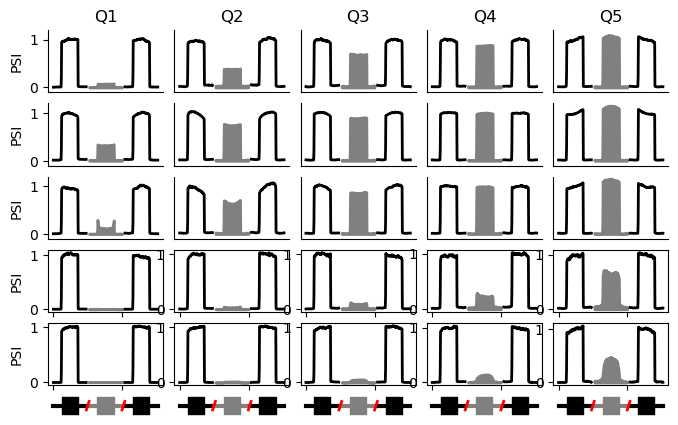

In [123]:
fig, axes = plt.subplots(ncols=5, nrows = 6, figsize = (8, 5), gridspec_kw={'wspace':0.1, 'height_ratios': [1, 1, 1, 1, 1, 0.3]})
plot_tissue_quintiles_for_snmf(Y.loc[Y.annot.isin(annot_by_both)], X.loc[X.annot.isin(annot_by_both)], 
                               Z.loc[Z.annot.isin(annot_by_both)], 'exons_by_both', '', 0, axes=axes)

plot_tissue_quintiles_for_snmf(Y.loc[Y.annot.isin(annot_by_any)], X.loc[X.annot.isin(annot_by_any)], 
                               Z.loc[Z.annot.isin(annot_by_any)], 'exons_by_both', '', 1, axes=axes)

plot_tissue_quintiles_for_snmf(Y.loc[Y.annot.isin(is_exon_only)], X.loc[X.annot.isin(is_exon_only)], 
                               Z.loc[Z.annot.isin(is_exon_only)], 'exons_by_both', '', 2, axes=axes)

plot_tissue_quintiles_for_snmf(Y.loc[Y.annot.isin(overlap_with_exon)], X.loc[X.annot.isin(overlap_with_exon)], 
                               Z.loc[Z.annot.isin(overlap_with_exon)], 'exons_by_both', '', 3, axes=axes)


plot_tissue_quintiles_for_snmf(Y.loc[Y.annot.isin(no_overlap)], X.loc[X.annot.isin(no_overlap)], 
                               Z.loc[Z.annot.isin(no_overlap)], 'exons_by_both', '', 4, axes=axes)


axes[0, 0].set_ylabel('PSI')
axes[1, 0].set_ylabel('PSI')
axes[2, 0].set_ylabel('PSI')
axes[3, 0].set_ylabel('PSI')
axes[4, 0].set_ylabel('PSI')

axes[0, 0].set_title('Q1')
axes[0, 1].set_title('Q2')
axes[0, 2].set_title('Q3')
axes[0, 3].set_title('Q4')
axes[0, 4].set_title('Q5')





for i in range(5):
    axes[5, i].plot([0, 120], [0.5, 0.5], c='black', zorder=1, linewidth = 3)
    axes[5, i].plot([130, 250], [0.5, 0.5], c='gray', zorder=1, linewidth = 3)
    axes[5, i].plot([260, 380], [0.5, 0.5], c='black', zorder=1, linewidth = 3)
    axes[5, i].plot([120, 130], [0.25, 0.75], c='red', zorder=1, linewidth=2)
    axes[5, i].plot([250, 260], [0.25, 0.75], c='red', zorder=1, linewidth=2)
    axes[5, i].fill_between(np.arange(30, 90), [0]*60, [1]*60, color='black', zorder=2)
    axes[5, i].fill_between(np.arange(30, 90)+130, [0]*60, [1]*60, color='gray', zorder=2)
    axes[5, i].fill_between(np.arange(30, 90)+260, [0]*60, [1]*60, color='black', zorder=2)
    axes[5, i].set_xticks([])
    axes[5, i].set_yticks([])
    axes[5, i].spines['top'].set_visible(False)
    axes[5, i].spines['right'].set_visible(False)
    axes[5, i].spines['bottom'].set_visible(False)
    axes[5, i].spines['left'].set_visible(False)

    for j in range(3):
        if i > 0:
            axes[j, i].set_yticks([])
    
        axes[j, i].set_ylim([-0.1, 1.2])
        axes[j, i].set_xticks([])
        axes[j, i].spines['top'].set_visible(False)
        axes[j, i].spines['right'].set_visible(False)


plt.savefig('../code/scratch_figures/figure2/cassette_exons.snmf_annot.pdf', bbox_inches='tight')
plt.savefig('../code/scratch_figures/figure2/cassette_exons.snmf_annot.png', bbox_inches='tight', dpi=500)

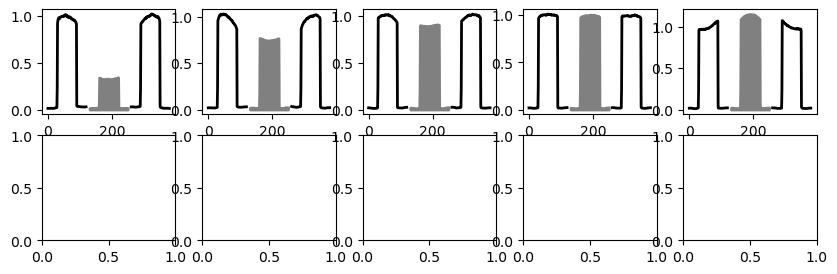

In [109]:
fig, axes = plt.subplots(ncols=5, nrows = 2, figsize = (10, 3))
plot_tissue_quintiles_for_snmf(Y.loc[Y.annot.isin(annot_by_any)], X.loc[X.annot.isin(annot_by_any)], 
                               Z.loc[Z.annot.isin(annot_by_any)], 'exons_by_both', '', 0, axes=axes)

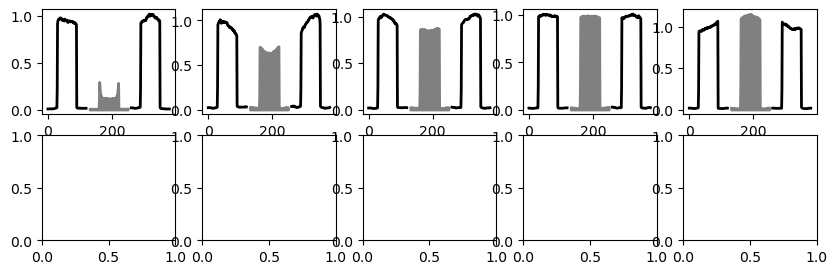

In [110]:
fig, axes = plt.subplots(ncols=5, nrows = 2, figsize = (10, 3))
plot_tissue_quintiles_for_snmf(Y.loc[Y.annot.isin(is_exon_only)], X.loc[X.annot.isin(is_exon_only)], 
                               Z.loc[Z.annot.isin(is_exon_only)], 'exons_by_both', '', 0, axes=axes)


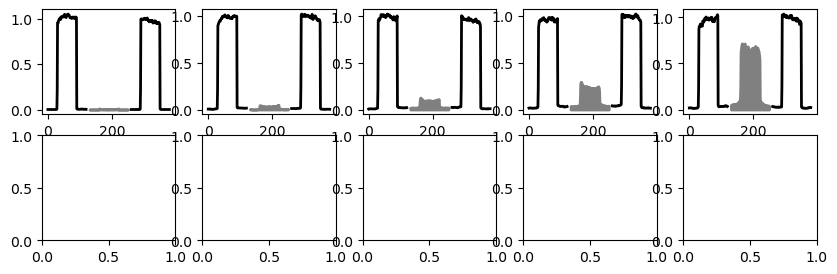

In [113]:
fig, axes = plt.subplots(ncols=5, nrows = 2, figsize = (10, 3))
plot_tissue_quintiles_for_snmf(Y.loc[Y.annot.isin(overlap_with_exon)], X.loc[X.annot.isin(overlap_with_exon)], 
                               Z.loc[Z.annot.isin(overlap_with_exon)], 'exons_by_both', '', 0, axes=axes)

In [111]:
no_overlap

Index(['chr1:954960:954976:954523:955923',
       'chr1:1758068:1758128:1757310:1761952',
       'chr1:1935732:1937538:1930336:1938855',
       'chr1:1949628:1952658:1947054:1955691',
       'chr1:2155079:2155661:2150978:2155995',
       'chr1:2169839:2171285:2169604:2171553',
       'chr1:2363693:2369099:2358715:2372481',
       'chr1:3161295:3167133:3069296:3186125',
       'chr1:3312756:3312996:3244137:3385152',
       'chr1:3475355:3475736:3474782:3475970',
       ...
       'chrX:132860454:132881430:132669199:132956808',
       'chrX:133655468:133655483:133596599:133661730',
       'chrX:133979635:133979749:133953211:133985275',
       'chrX:136222039:136222054:136220963:136222393',
       'chrX:150480451:150483562:150473802:150503274',
       'chrX:153502513:153502567:153495113:153504621',
       'chrX:155288366:155288540:155280068:155298785',
       'chrX:155288366:155289854:155280068:155298785',
       'chrX:155509848:155510061:155507134:155511673',
       'chrX:155573307:15557

In [82]:
fk1, exon, fk2 = load_matrices_per_tissue('Liver', 'vastdb', 'intron_only')

In [83]:
exon.shape

(10812, 126)

In [136]:
def load_matrices_per_tissue(tissue, annotation, exon_type):
    col_names = ['chrom', 'start', 'end', 'gene', 'score', 'strand']
    pos_names = [f'bin_{str(i+1)}' for i in range(120)]
    
    col_names += pos_names
    fk1 = pd.read_csv(f'../code/CoveragePlots/matrices/cassette_exons/{tissue}.{annotation}.{exon_type}.flanking1.mat.gz', sep='\t', skiprows=1,
                             names=col_names)

    fk2 = pd.read_csv(f'../code/CoveragePlots/matrices/cassette_exons/{tissue}.{annotation}.{exon_type}.flanking2.mat.gz', sep='\t', skiprows=1,
                                 names=col_names)
    
    exon = pd.read_csv(f'../code/CoveragePlots/matrices/cassette_exons/{tissue}.{annotation}.{exon_type}.exon.mat.gz', sep='\t', skiprows=1,
                                 names=col_names)

    return fk1, exon, fk2
    
snmf_cassette_exons = pd.read_csv('../code/ebpmf_models/filtered/snmf_10/tables/cassette_exons.bed.gz', sep='\t')


col_names = ['chrom', 'start', 'end', 'gene', 'score', 'strand']
pos_names = [f'bin_{str(i+1)}' for i in range(120)]
gencode_snmf_cassette_exons = pd.read_csv('../code/CoveragePlots/bed_files/cassette_exons/gencode/cassette_exon.exon.bed', 
                                          sep='\t', names = ['chrom', 'start', 'end', 'name', 'transcripts'])


snmf_gencode_cassette_exons = pd.read_csv('../code/CoveragePlots/bed_files/cassette_exons/snmf/gencode.exon.bed',
                                          sep='\t', names = ['chrom', 'start', 'end', 'name', 'transcripts'])

snmf_gencode_fk1 = pd.read_csv('../code/CoveragePlots/bed_files/cassette_exons/snmf/gencode.flanking1.bed',
                                          sep='\t', names = ['chrom', 'start', 'end', 'name', 'transcripts'])
snmf_gencode_fk2 = pd.read_csv('../code/CoveragePlots/bed_files/cassette_exons/snmf/gencode.flanking2.bed',
                                          sep='\t', names = ['chrom', 'start', 'end', 'name', 'transcripts'])

fk1, exon, fk2 = load_matrices_per_tissue('Liver', 'gencode', 'cassette_exon')
gencode_exon = exon[['chrom', 'start', 'end']].copy()
gencode_exon['intron_start'] = fk1.end
gencode_exon['intron_end'] = fk2.start

gencode_exon['annot'] = gencode_exon.chrom + ':' + gencode_exon.start.astype(str) + ':' + gencode_exon.end.astype(str) + ':'+ gencode_exon.intron_start.astype(str) + ':' + gencode_exon.intron_end.astype(str) 

snmf_exon = snmf_gencode_cassette_exons[['chrom', 'start', 'end']].copy()
snmf_exon['intron_start'] = snmf_gencode_fk1.end
snmf_exon['intron_end'] = snmf_gencode_fk2.start

snmf_exon['annot'] = snmf_exon.chrom + ':' + snmf_exon.start.astype(str) + ':' + snmf_exon.end.astype(str) + ':' + snmf_exon.intron_start.astype(str) + ':' + snmf_exon.intron_end.astype(str) 

In [137]:
pd.Index(gencode_exon.annot).intersection(pd.Index(snmf_exon.annot))

Index(['chr1:973186:973326:973010:973500',
       'chr1:1212638:1212704:1212138:1212992',
       'chr1:1337018:1337055:1336515:1337977',
       'chr1:1487863:1487914:1486668:1489204',
       'chr1:1520548:1520617:1520306:1522744',
       'chr1:1624991:1625185:1624901:1625286',
       'chr1:1690976:1691393:1676846:1692449',
       'chr1:1755374:1755476:1754698:1756258',
       'chr1:1839190:1839238:1825499:1890820',
       'chr1:2193998:2194133:2193910:2194688',
       ...
       'chrX:150712342:150712365:150699300:150718625',
       'chrX:153546088:153546129:153543168:153547835',
       'chrX:153863368:153863379:153862894:153863477',
       'chrX:153941950:153942031:153941653:153942855',
       'chrX:154092184:154092307:154032557:154097604',
       'chrX:154352553:154352675:154352447:154352772',
       'chrX:154357251:154357274:154355072:154357434',
       'chrX:154414101:154414190:154413567:154419543',
       'chrX:154486228:154486333:154485979:154486537',
       'chrX:155046509:15504

In [123]:

col_names = ['chrom', 'start', 'end', 'gene', 'score', 'strand']
pos_names = [f'bin_{str(i+1)}' for i in range(120)]
vastdb_snmf_cassette_exons = pd.read_csv('../code/CoveragePlots/bed_files/cassette_exons/vastdb/cassette_exon.exon.bed', 
                                          sep='\t', names = ['chrom', 'start', 'end', 'name', 'transcripts'])


snmf_vastdb_cassette_exons = pd.read_csv('../code/CoveragePlots/bed_files/cassette_exons/snmf/vastdb.exon.bed',
                                          sep='\t', names = ['chrom', 'start', 'end', 'name', 'transcripts'])

snmf_vastdb_fk1 = pd.read_csv('../code/CoveragePlots/bed_files/cassette_exons/snmf/vastdb.flanking1.bed',
                                          sep='\t', names = ['chrom', 'start', 'end', 'name', 'transcripts'])
snmf_vastdb_fk2 = pd.read_csv('../code/CoveragePlots/bed_files/cassette_exons/snmf/vastdb.flanking2.bed',
                                          sep='\t', names = ['chrom', 'start', 'end', 'name', 'transcripts'])

fk1, exon, fk2 = load_matrices_per_tissue('Liver', 'vastdb', 'cassette_exon')
vastdb_exon = exon[['chrom', 'start', 'end']].copy()
vastdb_exon['intron_start'] = fk1.end
vastdb_exon['intron_end'] = fk2.start

vastdb_exon['annot'] = vastdb_exon.chrom + ':' + vastdb_exon.start.astype(str) + ':' + vastdb_exon.end.astype(str) + ':'+ vastdb_exon.intron_start.astype(str) + ':' + vastdb_exon.intron_end.astype(str) 

snmf_exon = snmf_vastdb_cassette_exons[['chrom', 'start', 'end']].copy()
snmf_exon['intron_start'] = snmf_vastdb_fk1.end
snmf_exon['intron_end'] = snmf_vastdb_fk2.start

snmf_exon['annot'] = snmf_exon.chrom + ':' + snmf_exon.start.astype(str) + ':' + snmf_exon.end.astype(str) + ':' + snmf_exon.intron_start.astype(str) + ':' + snmf_exon.intron_end.astype(str) 

Index(['chr17:69178920:69179008:69175513:69182153',
       'chr1:202954241:202954307:202951164:202958185',
       'chr19:50512661:50512810:50512580:50512927',
       'chr12:89598590:89598743:89591295:89599117',
       'chr22:24588679:24589265:24588329:24589821',
       'chr3:43090488:43090609:43081536:43105836',
       'chr12:120526457:120526546:120522363:120528940',
       'chr9:129109179:129109277:129108077:129110483',
       'chr11:33156708:33156803:33141986:33161299',
       'chr19:42202051:42202072:42199829:42209700',
       ...
       'chr1:28623946:28624030:28622165:28642992',
       'chr2:240734719:240734745:240726940:240737063',
       'chr6:3284936:3284959:3283975:3285079',
       'chr11:85711113:85711232:85709500:85714413',
       'chr13:79353153:79353224:79344794:79354439',
       'chr12:49646639:49646753:49645903:49646886',
       'chr8:143791666:143791740:143791440:143791876',
       'chr16:4206727:4208104:4204634:4242007',
       'chr18:76988495:76988527:76984894:7698887

In [133]:

vastdb_exons_df = pd.read_csv('/project2/yangili1/cfbuenabadn/CSQ_additional_files/EVENT_INFO-hg38.tab.gz', sep='\t')
vastdb_exons_df = vastdb_exons_df.dropna()
vastdb_exons_cols = list(vastdb_exons_df.columns)
vastdb_exons_df['chrom'] = vastdb_exons_df.CO_A.apply(lambda x: x.split(':')[0])
vastdb_exons_df['start'] = vastdb_exons_df.CO_A.apply(lambda x: x.split(':')[1].split('-')[0])
vastdb_exons_df['end'] = vastdb_exons_df.CO_A.apply(lambda x: x.split('-')[1])
vastdb_exons_cols = ['chrom', 'start', 'end'] + vastdb_exons_cols
vastdb_exons_df = vastdb_exons_df[vastdb_exons_cols]

vastdb_exons_df = vastdb_exons_df.loc[(~vastdb_exons_df.COMPLEX.isin(['MIC-S', 'MIC_S', 'IR', 'Alt3', 'Alt5', 'MIC-M'])) & (vastdb_exons_df.EVENT.apply(lambda x: x.startswith('HsaEX')))]
vastdb_exons_df = vastdb_exons_df.loc[(~ vastdb_exons_df.COMPLEX.apply(lambda x: (x.startswith('ME') or (x == 'A_NA') or (x == 'ANN') or x == 'NA*')))]
vastdb_exons_df = vastdb_exons_df[[x for x in vastdb_exons_df.columns if x not in ['Seq_C1', 'Seq_A', 'Seq_C2']]]
vastdb_exons_df['strand'] = vastdb_exons_df.REF_CO.apply(lambda x: x.split(':')[-1])

intron_start_list = []
intron_end_list = []
for idx, row in vastdb_exons_df.iterrows():
    strand = row.strand
    if strand == '+':
        intron_start = int(row.CO_C1.split('-')[-1])
        intron_end = int(row.CO_C2.split('-')[0].split(':')[1])
    else:
        intron_start = int(row.CO_C2.split('-')[-1])
        intron_end = int(row.CO_C1.split('-')[0].split(':')[1])
        
    intron_start_list.append(intron_start)
    intron_end_list.append(intron_end)

vastdb_introns_df = pd.DataFrame()
vastdb_introns_df['chrom'] = list(vastdb_exons_df.chrom)
vastdb_introns_df['start'] = intron_start_list
vastdb_introns_df['end'] = intron_end_list
vastdb_introns_df['GENE'] = list(vastdb_exons_df.GENE)
vastdb_introns_df['EVENT'] = list(vastdb_exons_df.EVENT)
vastdb_introns_df['strand'] = list(vastdb_exons_df.strand)

vastdb_introns_bed = BedTool.from_dataframe(vastdb_introns_df).sort()
vastdb_exons_bed = BedTool.from_dataframe(vastdb_exons_df).sort()


snmf_cassette_exons = pd.read_csv('../code/ebpmf_models/filtered/snmf_10/tables/cassette_exons.bed.gz', sep='\t')
snmf_cassette_exons_bed = BedTool.from_dataframe(snmf_cassette_exons)

snmf_vastdb_cassette_exons = snmf_cassette_exons_bed.intersect(vastdb_exons_bed, f=1, F=1, wo=True).to_dataframe(
    names = list(snmf_cassette_exons.columns) + [f'{x}_vastdb' for x in vastdb_exons_df.columns] + ['overlaps']
)


intron_start_vastdb = []
intron_end_vastdb = []
for idx, row in snmf_vastdb_cassette_exons.iterrows():
    if row.strand_vastdb == '+':
        intron_start = row.CO_C1_vastdb
        intron_end = row.CO_C2_vastdb
    else:
        intron_start = row.CO_C2_vastdb
        intron_end = row.CO_C1_vastdb
    intron_start = int(intron_start.split('-')[-1])
    intron_end = int(intron_end.split(':')[-1].split('-')[0])

    intron_start_vastdb.append(intron_start)
    intron_end_vastdb.append(intron_end)

snmf_vastdb_cassette_exons['intron_start_vastdb'] = intron_start_vastdb
snmf_vastdb_cassette_exons['intron_end_vastdb'] = intron_end_vastdb

snmf_vastdb_cassette_exons_confirmed = snmf_vastdb_cassette_exons.loc[
(snmf_vastdb_cassette_exons.intron_start == snmf_vastdb_cassette_exons.intron_start_vastdb) & (snmf_vastdb_cassette_exons.intron_end == snmf_vastdb_cassette_exons.intron_end_vastdb)
]

In [141]:
snmf_vastdb_cassette_exons_confirmed['annot'] = snmf_vastdb_cassette_exons_confirmed[
['chrom', 'start', 'end', 'intron_start', 'intron_end']].astype(str).agg(':'.join, axis=1)

/tmp/jobs/41523640/ipykernel_27599/3589894801.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  snmf_vastdb_cassette_exons_confirmed['annot'] = snmf_vastdb_cassette_exons_confirmed[


In [182]:
pd.Index(snmf_vastdb_cassette_exons_confirmed.annot).intersection(pd.Index(gencode_exon.annot).intersection(pd.Index(snmf_exon.annot)))

Index(['chr1:973186:973326:973010:973500',
       'chr1:1212638:1212704:1212138:1212992',
       'chr1:1337018:1337055:1336515:1337977',
       'chr1:1487863:1487914:1486668:1489204',
       'chr1:1624991:1625185:1624901:1625286',
       'chr1:1755374:1755476:1754698:1756258',
       'chr1:2193998:2194133:2193910:2194688',
       'chr1:2389925:2389996:2388337:2391458',
       'chr1:2497502:2497609:2497010:2498523',
       'chr1:2521718:2521800:2521315:2526464',
       ...
       'chrX:150659664:150659756:150658027:150660371',
       'chrX:150712342:150712365:150699300:150718625',
       'chrX:153546088:153546129:153543168:153547835',
       'chrX:153863368:153863379:153862894:153863477',
       'chrX:153941950:153942031:153941653:153942855',
       'chrX:154092184:154092307:154032557:154097604',
       'chrX:154352553:154352675:154352447:154352772',
       'chrX:154357251:154357274:154355072:154357434',
       'chrX:154414101:154414190:154413567:154419543',
       'chrX:154486228:15448

In [183]:
pd.Index(snmf_vastdb_cassette_exons_confirmed.annot).union(pd.Index(gencode_exon.annot).intersection(pd.Index(snmf_exon.annot)))

Index(['chr10:100190869:100190968:100189627:100193298',
       'chr10:100202088:100202149:100200780:100204506',
       'chr10:100219270:100219359:100219132:100220588',
       'chr10:100260218:100260319:100256476:100260966',
       'chr10:100286097:100286213:100281053:100286605',
       'chr10:100497135:100497280:100496431:100497667',
       'chr10:100498705:100498804:100498207:100499160',
       'chr10:100500110:100500159:100499598:100502254',
       'chr10:101009250:101009350:101008850:101010272',
       'chr10:101020618:101020678:101019217:101021798',
       ...
       'chrX:80733456:80733496:80730020:80734118',
       'chrX:81202437:81202576:81202245:81276984',
       'chrX:84097772:84097848:84096311:84102037',
       'chrX:84134782:84134819:84120027:84135104',
       'chrX:84146978:84147058:84145557:84148042',
       'chrX:84475251:84475397:84469575:84502342',
       'chrX:85267278:85267415:85265255:85268294',
       'chrX:8587794:8587978:8585396:8597034',
       'chrX:85878965:858

In [144]:
pd.Index(gencode_exon.annot).intersection(pd.Index(snmf_exon.annot))

Index(['chr1:973186:973326:973010:973500',
       'chr1:1212638:1212704:1212138:1212992',
       'chr1:1337018:1337055:1336515:1337977',
       'chr1:1487863:1487914:1486668:1489204',
       'chr1:1520548:1520617:1520306:1522744',
       'chr1:1624991:1625185:1624901:1625286',
       'chr1:1690976:1691393:1676846:1692449',
       'chr1:1755374:1755476:1754698:1756258',
       'chr1:1839190:1839238:1825499:1890820',
       'chr1:2193998:2194133:2193910:2194688',
       ...
       'chrX:150712342:150712365:150699300:150718625',
       'chrX:153546088:153546129:153543168:153547835',
       'chrX:153863368:153863379:153862894:153863477',
       'chrX:153941950:153942031:153941653:153942855',
       'chrX:154092184:154092307:154032557:154097604',
       'chrX:154352553:154352675:154352447:154352772',
       'chrX:154357251:154357274:154355072:154357434',
       'chrX:154414101:154414190:154413567:154419543',
       'chrX:154486228:154486333:154485979:154486537',
       'chrX:155046509:15504

In [126]:
gencode_exons_file = '/project2/mstephens/cfbuenabadn/gtex-stm/code/Annotations/gencode.v44.primary_assembly.exons.sorted.bed.gz'
gencode_exons_df = pd.read_csv(gencode_exons_file, sep='\t', 
                            names = ['chrom', 'start', 'end', 'gene_id', 
                                                           'transcript_id', 'strand', 'exon_id', 'transcript_support_level',
                                                           'basic', 'Ensembl_canonical', 'MANE_Select', 'appris', 'transcript_type'])


In [127]:
gencode_exons_bed = BedTool.from_dataframe(gencode_exons_df)

In [129]:
snmf_cassette_exons_bed.intersect(gencode_exons_bed, f=1, F=1, u=True).to_dataframe(names = snmf_cassette_exons.columns)

,chrom,start,end,gene,exon_coordinates,strand,intron_start,intron_end,flanking1_start,flanking2_end,transcripts,exon_name
0,chr1,948131,948232,ENSG00000188976,chr1:948131-948232,-,946545,948490,946402,948603,ENSG00000188976.isoform_1|ENSG00000188976.isof...,ENSG00000188976:1
1,chr1,952000,952139,ENSG00000188976,chr1:952000-952139,-,951238,952412,951127,952600,ENSG00000188976.isoform_1|ENSG00000188976.isof...,ENSG00000188976:1
2,chr1,956095,956215,ENSG00000188976,chr1:956095-956215,-,956013,956894,955923,957025,ENSG00000188976.isoform_1|ENSG00000188976.isof...,ENSG00000188976:1
3,chr1,964107,964180,ENSG00000187961,chr1:964107-964180,+,964008,964349,963920,964530,ENSG00000187961.isoform_2|ENSG00000187961.isof...,ENSG00000187961:1
4,chr1,973186,973326,ENSG00000187583,chr1:973186-973326,+,973010,973500,972861,973640,ENSG00000187583.isoform_1|ENSG00000187583.isof...,ENSG00000187583:1
...,...,...,...,...,...,...,...,...,...,...,...,...
18609,chrX,154863083,154863227,ENSG00000185010,chrX:154863083-154863227,-,154861866,154880941,154861718,154885611,ENSG00000185010.isoform_2,ENSG00000185010:1
18610,chrX,154901371,154901442,ENSG00000185010,chrX:154901371-154901442,-,154899951,154902051,154899866,154902167,ENSG00000185010.isoform_4|ENSG00000185010.isof...,ENSG00000185010:1
18611,chrX,154987237,154987305,ENSG00000185010,chrX:154987237-154987305,-,154984803,154992936,154984687,154993148,ENSG00000185010.isoform_8,ENSG00000185010:1
18612,chrX,155046509,155046584,ENSG00000165775,chrX:155046509-155046584,+,155033553,155051670,155033403,155051801,ENSG00000165775.isoform_1,ENSG00000165775:1


In [131]:
snmf_gencode_exons = snmf_cassette_exons_bed.intersect(gencode_exons_bed, f=1, F=1, u=True).to_dataframe(names = snmf_cassette_exons.columns)
snmf_vastdb_exons = snmf_cassette_exons_bed.intersect(vastdb_exons_bed, f=1, F=1, u=True).to_dataframe(names = snmf_cassette_exons.columns)

In [175]:
snmf_vastdb_exons['annot'] = snmf_vastdb_exons[
['chrom', 'start', 'end', 'intron_start', 'intron_end']].astype(str).agg(':'.join, axis=1)

snmf_gencode_exons['annot'] = snmf_gencode_exons[
['chrom', 'start', 'end', 'intron_start', 'intron_end']].astype(str).agg(':'.join, axis=1)

snmf_junctions_cassette_exons

In [181]:
pd.Index(snmf_gencode_exons.annot).intersection(pd.Index(snmf_vastdb_exons.annot))

Index(['chr1:973186:973326:973010:973500', 'chr1:974316:974364:974051:974442',
       'chr1:1041173:1041397:1040880:1041478',
       'chr1:1046820:1046957:1046735:1047327',
       'chr1:1084481:1084506:1082987:1085878',
       'chr1:1087502:1087597:1087204:1090353',
       'chr1:1212638:1212704:1212138:1212992',
       'chr1:1244191:1244275:1244105:1244381',
       'chr1:1263346:1263386:1257310:1267862',
       'chr1:1294402:1294628:1294199:1294718',
       ...
       'chrX:154486228:154486333:154485979:154486537',
       'chrX:154511848:154511871:154508597:154512823',
       'chrX:154512314:154512411:154508597:154512823',
       'chrX:154563959:154564020:154563701:154564319',
       'chrX:154695917:154696019:154680248:154697132',
       'chrX:154784028:154784108:154783507:154785051',
       'chrX:154863083:154863227:154861866:154880941',
       'chrX:154901371:154901442:154899951:154902051',
       'chrX:154987237:154987305:154984803:154992936',
       'chrX:155116711:155116754:155116

In [186]:
pd.Index(snmf_gencode_exons.annot).union(pd.Index(snmf_vastdb_exons.annot)).unique()

Index(['chr10:100178133:100178194:100176070:100185514',
       'chr10:100179201:100179247:100178194:100183756',
       'chr10:100190869:100190968:100189627:100193298',
       'chr10:100202088:100202149:100200780:100204506',
       'chr10:100219270:100219359:100219132:100220588',
       'chr10:100250248:100250332:100246935:100253421',
       'chr10:100260218:100260319:100256476:100260966',
       'chr10:100286097:100286213:100281053:100286605',
       'chr10:100356532:100356764:100354632:100360734',
       'chr10:100497135:100497280:100496431:100497667',
       ...
       'chrX:84097772:84097848:84096311:84102037',
       'chrX:84134782:84134819:84120027:84135104',
       'chrX:84146978:84147058:84145557:84148042',
       'chrX:84475251:84475397:84469575:84502342',
       'chrX:85054344:85054398:85051508:85055827',
       'chrX:85067127:85067218:85055925:85073998',
       'chrX:85267278:85267415:85265255:85268294',
       'chrX:8587794:8587978:8585396:8597034',
       'chrX:85878965:858

In [154]:
snmf_cassette_exons.shape

(28464, 12)

In [166]:
len(pd.Index(snmf_junctions_cassette_exons.name).union(pd.Index(snmf_vastdb_exons.exon_name).union(pd.Index(snmf_gencode_exons.exon_name))).unique())

7746

In [189]:
len(pd.Index(snmf_vastdb_exons.annot).intersection(pd.Index(snmf_gencode_exons.annot)))

16517

In [190]:
len(pd.Index(snmf_vastdb_exons.annot).union(pd.Index(snmf_gencode_exons.annot)))

18629

Index(['chr1:973186:973326:973010:973500',
       'chr1:1212638:1212704:1212138:1212992',
       'chr1:1337018:1337055:1336515:1337977',
       'chr1:1487863:1487914:1486668:1489204',
       'chr1:1624991:1625185:1624901:1625286',
       'chr1:1755374:1755476:1754698:1756258',
       'chr1:2193998:2194133:2193910:2194688',
       'chr1:2389925:2389996:2388337:2391458',
       'chr1:2497502:2497609:2497010:2498523',
       'chr1:2521718:2521800:2521315:2526464',
       ...
       'chrX:150659664:150659756:150658027:150660371',
       'chrX:150712342:150712365:150699300:150718625',
       'chrX:153546088:153546129:153543168:153547835',
       'chrX:153863368:153863379:153862894:153863477',
       'chrX:153941950:153942031:153941653:153942855',
       'chrX:154092184:154092307:154032557:154097604',
       'chrX:154352553:154352675:154352447:154352772',
       'chrX:154357251:154357274:154355072:154357434',
       'chrX:154414101:154414190:154413567:154419543',
       'chrX:154486228:15448

In [293]:
snmf_cassette_exons['annot'] =  snmf_cassette_exons[
['chrom', 'start', 'end', 'intron_start', 'intron_end']].astype(str).agg(':'.join, axis=1)

In [296]:
exons_by_both = pd.Index(snmf_cassette_exons.loc[snmf_cassette_exons.annot.isin(pd.Index(snmf_vastdb_cassette_exons_confirmed.annot).intersection(pd.Index(gencode_exon.annot).intersection(pd.Index(snmf_exon.annot))))].transcripts)

In [341]:
28464 - 19068

9396

In [338]:
19068 - 13058#(18629)# - 3003

6010

In [336]:
13058 - 3003

10055

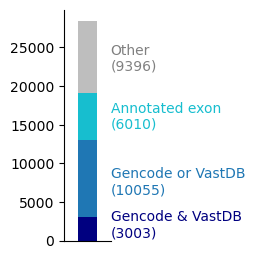

In [383]:
fig, ax = plt.subplots(figsize=(0.6, 3))
ax.bar([0], [28464], color='tab:gray', alpha=0.5, label='Other')
ax.bar([0], [19068], color='tab:cyan', label='Annotated exon')
# ax.bar([0], [18629], color='tab:green')
ax.bar([0], [13058], color='tab:blue', label='Annotated\ncassette exon')
ax.bar([0], [3003], color='navy', label='Gencode & VastDB\ncassette exon')
ax.set_xlim([-1, 1])
ax.spines[['right', 'top']].set_visible(False)
ax.set_xticks([])
ax.text(1, 500, 'Gencode & VastDB\n(3003)', c='navy')
ax.text(1, 6000, 'Gencode or VastDB\n(10055)', c='tab:blue')
ax.text(1, 14500, 'Annotated exon\n(6010)', c='tab:cyan')
ax.text(1, 22000, 'Other\n(9396)', c='gray')
# ax.legend(frameon=False, bbox_to_anchor =(2, 0.5))

plt.savefig('../code/scratch_figures/figure2/cassette_exons.barplot.pdf', bbox_inches='tight')
plt.savefig('../code/scratch_figures/figure2/cassette_exons.barplot.png', bbox_inches='tight', dpi=500)

In [1]:
6010+10055+3003

19068

In [378]:
28464 - 9396

19068

In [379]:
6010 + 10055+3003

19068

In [211]:
19068 - 18629

439

In [213]:
len(pd.Index(snmf_junctions_cassette_exons.transcripts).unique())

15003

In [216]:
transcripts_annotated = pd.Index(snmf_gencode_exons.transcripts).union(pd.Index(snmf_vastdb_exons.transcripts)).union(
    pd.Index(snmf_junctions_cassette_exons.transcripts).unique()
)

In [220]:
transcripts_unannotated = pd.Index(snmf_cassette_exons.transcripts).difference(transcripts_annotated).unique()

In [226]:
isoforms_for_annotated = []
for transcript in transcripts_annotated:
    isoforms_for_annotated.extend(transcript.split('|'))

isoforms_for_annotated = sorted(set(isoforms_for_annotated))

isoforms_for_unannotated = []
for transcript in transcripts_unannotated:
    isoforms_for_unannotated.extend(transcript.split('|'))

isoforms_for_unannotated = sorted(set(isoforms_for_unannotated))


In [363]:
isoforms_anot_L = []
for transcript in tqdm(transcripts_annotated, position=0, leave=True):
    isoforms_for_annotated = transcript.split('|')
    idx = EL.index.intersection(pd.Index(isoforms_for_annotated))
    if len(idx) > 0:
        isoforms_anot_L.append(EL.loc[EL.index.intersection(pd.Index(isoforms_for_annotated)), EL.columns[5:]].sum(axis=0).mean())
    else:
        isoforms_anot_L.append(0)


isoforms_unanot_L = []
for transcript in tqdm(transcripts_unannotated, position=0, leave=True):
    isoforms_for_unannotated = transcript.split('|')
    idx = EL.index.intersection(pd.Index(isoforms_for_unannotated))
    if len(idx) > 0:
        isoforms_unanot_L.append(EL.loc[EL.index.intersection(pd.Index(isoforms_for_unannotated)), EL.columns[5:]].sum(axis=0).mean())
    else:
        isoforms_unanot_L.append(0)

# isoforms_for_annotated = sorted(set(isoforms_for_annotated))

# isoforms_for_unannotated = []
# for transcript in transcripts_unannotated:
#     isoforms_for_unannotated.extend(transcript.split('|'))

# isoforms_for_unannotated = sorted(set(isoforms_for_unannotated))


100%|███████████████████████████████████████| 7030/7030 [14:17<00:00,  8.20it/s]


{'whiskers': [<matplotlib.lines.Line2D at 0x7f59580c04c0>,
 'caps': [<matplotlib.lines.Line2D at 0x7f59580c0a00>,
 'boxes': [<matplotlib.lines.Line2D at 0x7f59580c0220>,
 'medians': [<matplotlib.lines.Line2D at 0x7f59580c0e20>,
 'fliers': [<matplotlib.lines.Line2D at 0x7f59580c10c0>,
 'means': []}

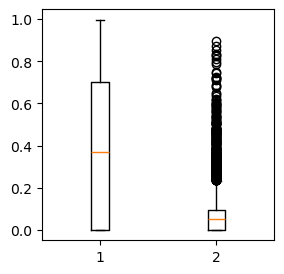

In [369]:
fig, ax = plt.subplots(figsize=(3, 3))
ax.boxplot([isoforms_anot_L, isoforms_unanot_L])

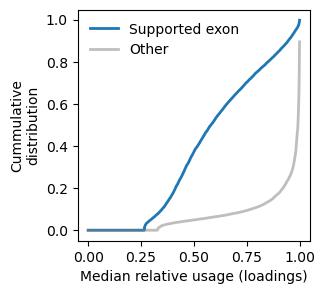

In [377]:
fig, ax = plt.subplots(figsize=(3, 3))

ax.plot(np.arange(len(isoforms_anot_L))/len(isoforms_anot_L), sorted(isoforms_anot_L), c='tab:blue', linewidth=2, label='Supported exon')
ax.plot(np.arange(len(isoforms_unanot_L))/len(isoforms_unanot_L), sorted(isoforms_unanot_L), c='tab:gray', alpha=0.5, linewidth=2, label='Other')
ax.set_xlabel('Median relative usage (loadings)')
ax.set_ylabel('Cummulative\ndistribution')
ax.legend(frameon=False)
# plt.plot(np.arange(len(EL_unannotated))/len(EL_unannotated), sorted(EL_unannotated))

plt.savefig('../code/scratch_figures/figure2/cassette_exons.relative_usage.pdf', bbox_inches='tight')
plt.savefig('../code/scratch_figures/figure2/cassette_exons.relative_usage.png', bbox_inches='tight', dpi=500)

In [297]:
isoforms_for_ce = []
for transcript in exons_by_both:
    isoforms_for_ce.extend(transcript.split('|'))

isoforms_for_ce = sorted(set(isoforms_for_ce))


In [317]:
transcripts_annotated

Index(['ENSG00000000457.isoform_1|ENSG00000000457.isoform_10|ENSG00000000457.isoform_9|ENSG00000000457.isoform_3|ENSG00000000457.isoform_7|ENSG00000000457.isoform_4|ENSG00000000457.isoform_5|ENSG00000000457.isoform_8',
       'ENSG00000000460.isoform_1|ENSG00000000460.isoform_2|ENSG00000000460.isoform_3',
       'ENSG00000000938.isoform_1|ENSG00000000938.isoform_2|ENSG00000000938.isoform_4|ENSG00000000938.isoform_3',
       'ENSG00000000938.isoform_5', 'ENSG00000001036.isoform_7',
       'ENSG00000001084.isoform_2|ENSG00000001084.isoform_4',
       'ENSG00000001084.isoform_5', 'ENSG00000001460.isoform_1',
       'ENSG00000001461.isoform_1|ENSG00000001461.isoform_4',
       'ENSG00000001461.isoform_1|ENSG00000001461.isoform_4|ENSG00000001461.isoform_2|ENSG00000001461.isoform_5',
       ...
       'ENSG00000281106.isoform_4', 'ENSG00000283071.isoform_1',
       'ENSG00000283361.isoform_1', 'ENSG00000283361.isoform_3',
       'ENSG00000283361.isoform_4', 'ENSG00000283361.isoform_6',
     

In [231]:
len(isoforms_for_annotated)

28520

In [232]:
len(isoforms_for_unannotated)

7186

In [234]:
EL = pd.read_csv('../code/ebpmf_models/filtered/snmf_10/tables/transcript.merged_isoforms.EL.bed.gz', sep='\t', index_col = 3)

In [287]:
EL_annotated = list(EL.loc[pd.Index(isoforms_for_annotated).intersection(EL.index), EL.columns[5:]].quantile(0.75, axis=1) - EL.loc[pd.Index(isoforms_for_annotated).intersection(EL.index), EL.columns[5:]].quantile(0.25, axis=1))
EL_annotated += [0]*len(pd.Index(isoforms_for_annotated).difference(EL.index))

In [288]:
EL_unannotated = list(EL.loc[pd.Index(isoforms_for_unannotated).intersection(EL.index), EL.columns[5:]].quantile(0.75, axis=1) - EL.loc[pd.Index(isoforms_for_unannotated).intersection(EL.index), EL.columns[5:]].quantile(0.25, axis=1))
EL_unannotated += [0]*len(pd.Index(isoforms_for_unannotated).difference(EL.index))

In [300]:
EL_ce = list(EL.loc[pd.Index(isoforms_for_ce).intersection(EL.index), EL.columns[5:]].quantile(0.75, axis=1) - EL.loc[pd.Index(isoforms_for_ce).intersection(EL.index), EL.columns[5:]].quantile(0.25, axis=1))
EL_ce += [0]*len(pd.Index(isoforms_for_ce).difference(EL.index))

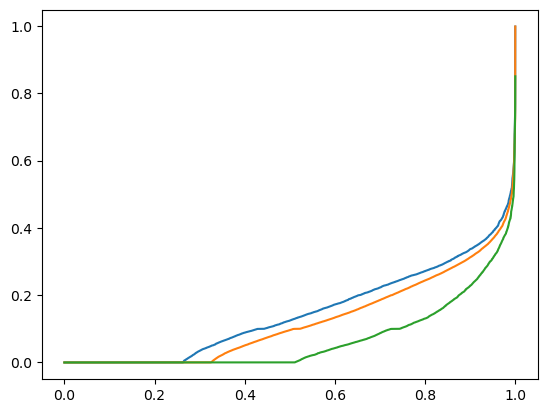

In [301]:
plt.plot(np.arange(len(EL_ce))/len(EL_ce), sorted(EL_ce))
plt.plot(np.arange(len(EL_annotated))/len(EL_annotated), sorted(EL_annotated))
plt.plot(np.arange(len(EL_unannotated))/len(EL_unannotated), sorted(EL_unannotated))

In [273]:
np.mean(EL_unannotated)

0.0677058520178126

In [208]:
len(pd.Index(snmf_junctions_cassette_exons.transcripts).difference(pd.Index(snmf_gencode_exons.transcripts).union(pd.Index(snmf_vastdb_exons.transcripts))))

439

In [197]:
snmf_junctions_cassette_exons

,chrom,start,end,name,transcripts
0,chr1,948131,948232,ENSG00000188976:1,ENSG00000188976.isoform_1|ENSG00000188976.isof...
1,chr1,952000,952139,ENSG00000188976:1,ENSG00000188976.isoform_1|ENSG00000188976.isof...
2,chr1,956095,956215,ENSG00000188976:1,ENSG00000188976.isoform_1|ENSG00000188976.isof...
3,chr1,964107,964180,ENSG00000187961:1,ENSG00000187961.isoform_2|ENSG00000187961.isof...
4,chr1,973186,973326,ENSG00000187583:1,ENSG00000187583.isoform_1|ENSG00000187583.isof...
...,...,...,...,...,...
16734,chrX,154901371,154901442,ENSG00000185010:1,ENSG00000185010.isoform_4|ENSG00000185010.isof...
16735,chrX,154987237,154987305,ENSG00000185010:1,ENSG00000185010.isoform_8
16736,chrX,155046509,155046584,ENSG00000165775:1,ENSG00000165775.isoform_1
16737,chrX,155116711,155116754,ENSG00000185515:1,ENSG00000185515.isoform_1|ENSG00000185515.isof...


In [153]:
pd.Index(snmf_vastdb_exons.exon_name).union(pd.Index(snmf_gencode_exons.exon_name))

Index(['ENSG00000000457:1', 'ENSG00000000460:1', 'ENSG00000000938:1',
       'ENSG00000000938:1', 'ENSG00000001036:1', 'ENSG00000001084:1',
       'ENSG00000001084:1', 'ENSG00000001460:1', 'ENSG00000001461:1',
       'ENSG00000001461:1',
       ...
       'ENSG00000281106:1', 'ENSG00000283071:1', 'ENSG00000283361:1',
       'ENSG00000283361:1', 'ENSG00000283361:1', 'ENSG00000283361:1',
       'ENSG00000283361:1', 'ENSG00000283378:1', 'ENSG00000283632:1',
       'ENSG00000283632:1'],
      dtype='object', name='exon_name', length=18627)

In [162]:
EL

,#Chr,start,end,pid,gid,strand,GTEX-1117F-0426-SM-5EGHI,GTEX-1122O-2426-SM-5GIDN,GTEX-1128S-2426-SM-5H11B,GTEX-113JC-2726-SM-5EGIS,...,GTEX-13PVQ-0011-R7a-SM-5L3G3,GTEX-13RTJ-0011-R7b-SM-5P9JS,GTEX-13VXU-0011-R7b-SM-5SI72,GTEX-13X6I-0011-R7b-SM-5PNWP,GTEX-13X6J-0011-R7b-SM-5PNUC,GTEX-1445S-0011-R7b-SM-5PNUG,GTEX-144GL-0011-R7b-SM-5P9HX,GTEX-144GO-0011-R7b-SM-5S2TT,GTEX-145MG-0011-R7b-SM-5P9JY,GTEX-145MH-0011-R7a-SM-5PNWH
0,chr20,50934820,50958581,ENSG00000000419.isoform_1,ENSG00000000419,-,0.8133,0.9408,0.9998,0.9165,...,0.8470,0.8935,0.7772,0.8562,0.9997,0.9349,0.8948,0.9993,0.9996,0.9998
1,chr20,50934820,50958581,ENSG00000000419.isoform_2,ENSG00000000419,-,0.0000,0.0001,0.0001,0.0373,...,0.0326,0.0136,0.0921,0.0785,0.0001,0.0002,0.0601,0.0003,0.0002,0.0001
2,chr20,50934820,50958581,ENSG00000000419.isoform_3,ENSG00000000419,-,0.1866,0.0590,0.0001,0.0462,...,0.1203,0.0929,0.1307,0.0653,0.0001,0.0651,0.0451,0.0003,0.0002,0.0001
3,chr1,169849654,169893945,ENSG00000000457.isoform_1,ENSG00000000457,-,0.0000,0.0000,0.0426,0.0000,...,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0001,0.0544,0.0000
4,chr1,169849654,169893945,ENSG00000000457.isoform_10,ENSG00000000457,-,0.0476,0.0000,0.0000,0.0001,...,0.0000,0.0000,0.0000,0.0001,0.0000,0.0001,0.0001,0.0001,0.0001,0.0000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
57908,chr6,159669019,159693290,ENSG00000291237.isoform_5,ENSG00000291237,-,0.0054,0.0000,0.0000,0.0000,...,0.0000,0.0006,0.0079,0.0000,0.0186,0.0000,0.0008,0.0000,0.0112,0.0031
57909,chr6,159669019,159693290,ENSG00000291237.isoform_6,ENSG00000291237,-,0.1053,0.1328,0.1148,0.0966,...,0.2497,0.3038,0.1623,0.1994,0.1876,0.2006,0.0638,0.2222,0.0622,0.2992
57910,chr6,159669019,159693290,ENSG00000291237.isoform_7,ENSG00000291237,-,0.0180,0.0293,0.0064,0.0475,...,0.0175,0.0671,0.0651,0.0831,0.0643,0.0961,0.1245,0.1232,0.1339,0.0557
57911,chr6,159669019,159693290,ENSG00000291237.isoform_8,ENSG00000291237,-,0.0911,0.1023,0.4469,0.0935,...,0.0035,0.0392,0.1501,0.0285,0.0569,0.0225,0.0566,0.0462,0.0001,0.0042


In [99]:
gencode_exon

,chrom,start,end,intron_start,intron_end,annot
0,chr1,973186,973326,973010,973500,chr1:973186:973326973010:973500
1,chr1,1212638,1212704,1212138,1212992,chr1:1212638:12127041212138:1212992
2,chr1,1337018,1337055,1336515,1337977,chr1:1337018:13370551336515:1337977
3,chr1,1454345,1454500,1452434,1455460,chr1:1454345:14545001452434:1455460
4,chr1,1487863,1487914,1486668,1489204,chr1:1487863:14879141486668:1489204
...,...,...,...,...,...,...
4083,chrX,154352553,154352675,154352447,154352772,chrX:154352553:154352675154352447:154352772
4084,chrX,154357251,154357274,154355072,154357434,chrX:154357251:154357274154355072:154357434
4085,chrX,154414101,154414190,154413567,154419543,chrX:154414101:154414190154413567:154419543
4086,chrX,154486228,154486333,154485979,154486537,chrX:154486228:154486333154485979:154486537


In [89]:
snmf_gencode_cassette_exons = pd.read_csv('../code/CoveragePlots/bed_files/cassette_exons/snmf/gencode.exon.bed',
                                          sep='\t', names = ['chrom', 'start', 'end', 'name', 'transcripts'])

snmf_vastdb_cassette_exons = pd.read_csv('../code/CoveragePlots/bed_files/cassette_exons/snmf/vastdb.exon.bed',
                                          sep='\t', names = ['chrom', 'start', 'end', 'name', 'transcripts'])

snmf_junctions_cassette_exons = pd.read_csv('../code/CoveragePlots/bed_files/cassette_exons/snmf/junctions.exon.bed',
                                          sep='\t', names = ['chrom', 'start', 'end', 'name', 'transcripts'])

snmf_cassette_exons = pd.read_csv('../code/ebpmf_models/filtered/snmf_10/tables/cassette_exons.bed.gz', sep='\t')


In [98]:
pd.Index(snmf_gencode_cassette_exons.name).intersection(pd.Index(snmf_vastdb_cassette_exons.name))

Index(['ENSG00000187583:1', 'ENSG00000186827:1', 'ENSG00000107404:1',
       'ENSG00000215915:1', 'ENSG00000160072:1', 'ENSG00000197530:1',
       'ENSG00000189339:1', 'ENSG00000008130:1', 'ENSG00000078369:1',
       'ENSG00000162585:1',
       ...
       'ENSG00000171100:1', 'ENSG00000063601:1', 'ENSG00000102181:1',
       'ENSG00000067842:1', 'ENSG00000198910:1', 'ENSG00000102032:1',
       'ENSG00000169057:1', 'ENSG00000196924:1', 'ENSG00000102125:1',
       'ENSG00000102178:1'],
      dtype='object', name='name', length=2858)

In [93]:
snmf_cassette_exons

,chrom,start,end,gene,exon_coordinates,strand,intron_start,intron_end,flanking1_start,flanking2_end,transcripts,exon_name
0,chr1,948131,948232,ENSG00000188976,chr1:948131-948232,-,946545,948490,946402,948603,ENSG00000188976.isoform_1|ENSG00000188976.isof...,ENSG00000188976:1
1,chr1,951844,952139,ENSG00000188976,chr1:951844-952139,-,951238,952412,951127,952600,ENSG00000188976.isoform_6,ENSG00000188976:1
2,chr1,952000,952139,ENSG00000188976,chr1:952000-952139,-,951238,952412,951127,952600,ENSG00000188976.isoform_1|ENSG00000188976.isof...,ENSG00000188976:1
3,chr1,954960,954976,ENSG00000188976,chr1:954960-954976,-,954523,955923,954004,956013,ENSG00000188976.isoform_3,ENSG00000188976:1
4,chr1,956095,956215,ENSG00000188976,chr1:956095-956215,-,956013,956894,955923,957025,ENSG00000188976.isoform_1|ENSG00000188976.isof...,ENSG00000188976:1
...,...,...,...,...,...,...,...,...,...,...,...,...
28459,chrX,155288366,155288540,ENSG00000155962,chrX:155288366-155288540,-,155280068,155298785,155279962,155298910,ENSG00000155962.isoform_2,ENSG00000155962:1
28460,chrX,155288366,155289854,ENSG00000155962,chrX:155288366-155289854,-,155280068,155298785,155279962,155298910,ENSG00000155962.isoform_4,ENSG00000155962:1
28461,chrX,155509848,155510061,ENSG00000185973,chrX:155509848-155510061,-,155507134,155511673,155504817,155511792,ENSG00000185973.isoform_1,ENSG00000185973:1
28462,chrX,155573307,155573493,ENSG00000185973,chrX:155573307-155573493,-,155545277,155612792,155541186,155612916,ENSG00000185973.isoform_4,ENSG00000185973:1


In [90]:
snmf_gencode_cassette_exons

,chrom,start,end,name,transcripts
0,chr1,973186,973326,ENSG00000187583:1,ENSG00000187583.isoform_1|ENSG00000187583.isof...
1,chr1,1212638,1212704,ENSG00000186827:1,ENSG00000186827.isoform_2|ENSG00000186827.isof...
2,chr1,1337018,1337055,ENSG00000107404:1,ENSG00000107404.isoform_1
3,chr1,1454345,1454500,ENSG00000215915:1,ENSG00000215915.isoform_7
4,chr1,1487863,1487914,ENSG00000160072:1,ENSG00000160072.isoform_1|ENSG00000160072.isof...
...,...,...,...,...,...
4060,chrX,154352553,154352675,ENSG00000196924:1,ENSG00000196924.isoform_1|ENSG00000196924.isof...
4061,chrX,154357251,154357274,ENSG00000196924:1,ENSG00000196924.isoform_6
4062,chrX,154414101,154414190,ENSG00000102125:1,ENSG00000102125.isoform_2|ENSG00000102125.isof...
4063,chrX,154486228,154486333,ENSG00000102178:1,ENSG00000102178.isoform_1


In [91]:
gencode_snmf_cassette_exons.shape

(4088, 5)

In [92]:
snmf_gencode_cassette_exons.shape

(4065, 5)

In [87]:
snmf_vastdb_cassette_exons

,chrom,start,end,name,transcripts
0,chr1,973186,973326,ENSG00000187583:1,ENSG00000187583.isoform_1|ENSG00000187583.isof...
1,chr1,974316,974364,ENSG00000187583:1,ENSG00000187583.isoform_10|ENSG00000187583.iso...
2,chr1,1041173,1041397,ENSG00000188157:1,ENSG00000188157.isoform_4
3,chr1,1046820,1046957,ENSG00000188157:1,ENSG00000188157.isoform_3|ENSG00000188157.isof...
4,chr1,1084481,1084506,ENSG00000131591:1,ENSG00000131591.isoform_10
...,...,...,...,...,...
16527,chrX,154784028,154784108,ENSG00000130830:1,ENSG00000130830.isoform_1
16528,chrX,154863083,154863227,ENSG00000185010:1,ENSG00000185010.isoform_2
16529,chrX,154901371,154901442,ENSG00000185010:1,ENSG00000185010.isoform_4|ENSG00000185010.isof...
16530,chrX,154987237,154987305,ENSG00000185010:1,ENSG00000185010.isoform_8


In [41]:
snmf_gencode_cassette_exons['coords'] = snmf_gencode_cassette_exons.chrom + ':' + snmf_gencode_cassette_exons.start.astype(str) + '-' + snmf_gencode_cassette_exons.end.astype(str) 

In [42]:
gencode_snmf_cassette_exons['coords'] = gencode_snmf_cassette_exons.chrom + ':' + gencode_snmf_cassette_exons.start.astype(str) + '-' + gencode_snmf_cassette_exons.end.astype(str) 

UFuncTypeError: ufunc 'add' did not contain a loop with signature matching types (dtype('int64'), dtype('<U1')) -> None

In [ ]:
np.mean([x in list(gencode_snmf_cassette_exons['coords']) for x in  list(snmf_gencode_cassette_exons.coords)])

In [150]:
snmf_vastdb_cassette_exons = pd.read_csv('../code/CoveragePlots/bed_files/cassette_exons/snmf/vastdb.exon.bed',
                                          sep='\t', names = ['chrom', 'start', 'end', 'name', 'transcripts'])

In [158]:
vastdb_snmf_cassette_exons = pd.read_csv('../code/CoveragePlots/bed_files/cassette_exons/vastdb/cassette_exon.exon.bed', 
                                          sep='\t', names = ['chrom', 'start', 'end', 'name'])

In [164]:
snmf_vastdb_cassette_exons

,chrom,start,end,name,transcripts
0,chr1,973186,973326,ENSG00000187583:1,ENSG00000187583.isoform_1|ENSG00000187583.isof...
1,chr1,974316,974364,ENSG00000187583:1,ENSG00000187583.isoform_10|ENSG00000187583.iso...
2,chr1,1041173,1041397,ENSG00000188157:1,ENSG00000188157.isoform_4
3,chr1,1046820,1046957,ENSG00000188157:1,ENSG00000188157.isoform_3|ENSG00000188157.isof...
4,chr1,1084481,1084506,ENSG00000131591:1,ENSG00000131591.isoform_10
...,...,...,...,...,...
16527,chrX,154784028,154784108,ENSG00000130830:1,ENSG00000130830.isoform_1
16528,chrX,154863083,154863227,ENSG00000185010:1,ENSG00000185010.isoform_2
16529,chrX,154901371,154901442,ENSG00000185010:1,ENSG00000185010.isoform_4|ENSG00000185010.isof...
16530,chrX,154987237,154987305,ENSG00000185010:1,ENSG00000185010.isoform_8


In [155]:
vastdb_snmf_cassette_exons.shape

(13121, 5)

In [159]:
vastdb_snmf_cassette_exons

,chrom,start,end,name
0,chr9,104845477,104845569,HsaEX0000219
1,chr17,69178920,69179008,HsaEX0000241
2,chr9,137013832,137014038,HsaEX0000253
3,chr12,21852368,21852505,HsaEX0000522
4,chr17,78005058,78005079,HsaEX0001162
...,...,...,...,...
13116,chr14,30918966,30919106,HsaEX0062638
13117,chr5,177491404,177491420,HsaEX0046423
13118,chr1,172093696,172093725,HsaEX0020459
13119,chr18,76988495,76988527,HsaEX0038144


In [2]:
import numpy as np
import pandas as pd
from pybedtools import BedTool
import gzip
from matplotlib import pyplot as plt
import seaborn as sns
from tqdm import tqdm

In [5]:
snmf_exons_file = '/project2/mstephens/cfbuenabadn/gtex-stm/code/ebpmf_models/filtered/snmf_10/tables/snmf.merged_isoforms.exons.sorted.bed.gz'
snmf_exons_df = pd.read_csv(snmf_exons_file, sep='\t', names = ['chrom', 'start', 'end', 'gene_id', 
                                                 'transcript_id', 'strand', 'factors', 'exon_id'])

snmf_introns_df = pd.read_csv('/project2/mstephens/cfbuenabadn/gtex-stm/code/snmf_introns.bed.gz', sep='\t')


In [7]:

annot_columns = ['chrom', 'start', 'end', 'gene_id', 'transcript_id', 'strand']

snmf_exons_df = snmf_exons_df.loc[(snmf_exons_df.end >= snmf_exons_df.start), annot_columns].drop_duplicates()
snmf_exons_bed = BedTool.from_dataframe(snmf_exons_df).sort()

In [8]:
vastdb_exons_df = pd.read_csv('/project2/yangili1/cfbuenabadn/CSQ_additional_files/EVENT_INFO-hg38.tab.gz', sep='\t')
vastdb_exons_df = vastdb_exons_df.dropna()
vastdb_exons_cols = list(vastdb_exons_df.columns)
vastdb_exons_df['chrom'] = vastdb_exons_df.CO_A.apply(lambda x: x.split(':')[0])
vastdb_exons_df['start'] = vastdb_exons_df.CO_A.apply(lambda x: x.split(':')[1].split('-')[0])
vastdb_exons_df['end'] = vastdb_exons_df.CO_A.apply(lambda x: x.split('-')[1])
vastdb_exons_cols = ['chrom', 'start', 'end'] + vastdb_exons_cols
vastdb_exons_df = vastdb_exons_df[vastdb_exons_cols]

vastdb_exons_df = vastdb_exons_df.loc[(~vastdb_exons_df.COMPLEX.isin(['MIC-S', 'MIC_S', 'IR', 'Alt3', 'Alt5', 'MIC-M'])) & (vastdb_exons_df.EVENT.apply(lambda x: x.startswith('HsaEX')))]
vastdb_exons_df = vastdb_exons_df.loc[(~ vastdb_exons_df.COMPLEX.apply(lambda x: (x.startswith('ME') or (x == 'A_NA') or (x == 'ANN') or x == 'NA*')))]
vastdb_exons_df = vastdb_exons_df[[x for x in vastdb_exons_df.columns if x not in ['Seq_C1', 'Seq_A', 'Seq_C2']]]
vastdb_exons_df['strand'] = vastdb_exons_df.REF_CO.apply(lambda x: x.split(':')[-1])

intron_start_list = []
intron_end_list = []
for idx, row in vastdb_exons_df.iterrows():
    strand = row.strand
    if strand == '+':
        intron_start = int(row.CO_C1.split('-')[-1])
        intron_end = int(row.CO_C2.split('-')[0].split(':')[1])
    else:
        intron_start = int(row.CO_C2.split('-')[-1])
        intron_end = int(row.CO_C1.split('-')[0].split(':')[1])
        
    intron_start_list.append(intron_start)
    intron_end_list.append(intron_end)

vastdb_introns_df = pd.DataFrame()
vastdb_introns_df['chrom'] = list(vastdb_exons_df.chrom)
vastdb_introns_df['start'] = intron_start_list
vastdb_introns_df['end'] = intron_end_list
vastdb_introns_df['GENE'] = list(vastdb_exons_df.GENE)
vastdb_introns_df['EVENT'] = list(vastdb_exons_df.EVENT)
vastdb_introns_df['strand'] = list(vastdb_exons_df.strand)

vastdb_introns_bed = BedTool.from_dataframe(vastdb_introns_df).sort()
vastdb_exons_bed = BedTool.from_dataframe(vastdb_exons_df).sort()

introns_columns = ['chrom', 'start', 'end', 'gene_id', 'transcript_id', 'strand']


In [10]:

snmf_introns_bed = BedTool.from_dataframe(snmf_introns_df.loc[snmf_introns_df.end >= snmf_introns_df.start]).sort()

In [11]:
snmf_vastdb_exon_overlaps = snmf_exons_bed.intersect(vastdb_exons_bed, f=1, F=1, wo=True).to_dataframe(
    names = annot_columns + ['vastdb_' + x for x in list(vastdb_exons_df.columns)] + ['overlap']
)

snmf_vastdb_intron_overlaps = snmf_introns_bed.intersect(vastdb_introns_bed, f=1, F=1, wo=True).to_dataframe(
    names = introns_columns + ['vastdb_' + x for x in list(vastdb_introns_df.columns)] + ['overlap']
)

snmf_vastdb_exons_captured = pd.Index(snmf_vastdb_exon_overlaps.vastdb_EVENT.unique())
snmf_vastdb_introns_captured = pd.Index(snmf_vastdb_intron_overlaps.vastdb_EVENT.unique())



In [12]:
psi = pd.read_csv('/project2/yangili1/cfbuenabadn/CSQ_additional_files/EVENT_METRICS-hg38.tab.gz', sep='\t', index_col=0)

def get_stats_range(psi, introns_captured, exons_captured, a, step=10):
    i = a*step
    exons_i = psi.loc[(psi.Average <= (i+step)) & (psi.Average >= i)].index

   

    skipped_only_pct, captured_both_pct, cassette_only_pct = get_stats(exons_i, exons_captured, introns_captured)

    skipped_only_pct_list = []
    captured_both_pct_list = []
    cassette_only_pct_list = []

    for n in range(30):
        k = np.max([int(len(exons_i)/10), 3])
        bootstrap = pd.Index(np.random.choice(exons_i, k, replace=False))
        skipped_only_pct_, captured_both_pct_, cassette_only_pct_ = get_stats(bootstrap, exons_captured, introns_captured)
        skipped_only_pct_list.append(skipped_only_pct_)
        captured_both_pct_list.append(captured_both_pct_)
        cassette_only_pct_list.append(cassette_only_pct_)
    
    

    return skipped_only_pct, captured_both_pct, cassette_only_pct, skipped_only_pct_list, captured_both_pct_list, cassette_only_pct_list

    
def get_stats(exons_i, exons_captured, introns_captured):
    
    if len(exons_i) == 0:
        return np.nan, np.nan, np.nan
        
    exon_inclusion = exons_i.intersection(exons_captured)
    skipped_exon = exons_i.intersection(introns_captured)
    
    captured_both = exon_inclusion.intersection(skipped_exon)
    skipped_only = skipped_exon.difference(exon_inclusion)
    cassette_only = exon_inclusion.difference(skipped_exon)

    captured_both_pct = len(captured_both)/len(exons_i)
    skipped_only_pct = len(skipped_only)/len(exons_i)
    cassette_only_pct = len(cassette_only)/len(exons_i)

    return skipped_only_pct, captured_both_pct, cassette_only_pct

In [13]:
snmf_cassette_exons_captured = snmf_vastdb_exons_captured.union(snmf_vastdb_introns_captured).intersection(psi.index)
psi_snmf = psi.loc[snmf_cassette_exons_captured]

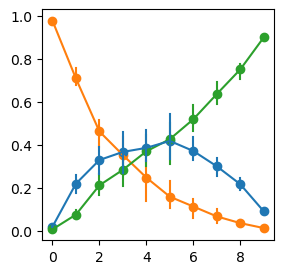

In [14]:
fig, ax = plt.subplots(figsize=(3, 3))
x = np.arange(0, 10)
y_skipped = []
y_both = []
y_cassette = []
for i in x:
    a, b, c, aa, bb, cc = get_stats_range(psi_snmf, snmf_vastdb_introns_captured, snmf_vastdb_exons_captured, i, 10)
    y_skipped.append(a)
    y_both.append(b)
    y_cassette.append(c)
    ax.scatter([i], [a], c='tab:orange')
    ax.plot([i, i], [np.quantile(aa, 0.1), np.quantile(aa, 0.9)], c='tab:orange', zorder=1)
    ax.scatter([i], [b], c='tab:blue')
    ax.plot([i, i], [np.quantile(bb, 0.1), np.quantile(bb, 0.9)], c='tab:blue', zorder=3)
    ax.scatter([i], [c], c='tab:green')
    ax.plot([i, i], [np.quantile(cc, 0.1), np.quantile(cc, 0.9)], c='tab:green', zorder=2)

ax.plot(x, y_skipped, c='tab:orange', zorder=1)
ax.plot(x, y_both, c='tab:blue', zorder=3)
ax.plot(x, y_cassette, c='tab:green', zorder=2)

In [15]:
psi_table = pd.read_csv('/project2/yangili1/cfbuenabadn/CSQ_additional_files/PSI_TABLE-hg38.tab.gz', sep='\t')

In [29]:
columnas = ['Brain_Endoth', 'Whole_Brain_b', 'Cortex', 'Heart_a', 'Heart_b', 'Heart_c', 'Liver_a', 'Liver_b', 'Liver_c', 'Lung_b', 'Lung_e',
'Lung_f', 'Muscle_b', 'Muscle_d', 'Muscle_e', 'Neurons', 'Skin_a', 'Skin_b', 'Skin_c', 'Skin_d', 'WBC_d', 'WBC_e']

In [34]:
psi_table = psi_table.set_index('EVENT')

In [49]:
psi_table['Brain_'] = psi_table[['Brain_Endoth', 'Whole_Brain_b', 'Cortex', 'Neurons']].median(axis=1)
psi_table['Heart_'] = psi_table[['Heart_a', 'Heart_b', 'Heart_c']].median(axis=1)
psi_table['Liver_'] = psi_table[['Liver_a', 'Liver_b', 'Liver_c']].median(axis=1)
psi_table['Lung_'] = psi_table[['Lung_b', 'Lung_e','Lung_f']].median(axis=1)
psi_table['Skin_'] = psi_table[['Skin_a', 'Skin_b', 'Skin_c', 'Skin_d']].median(axis=1)
psi_table['Blood_'] = psi_table[['WBC_d', 'WBC_e']].median(axis=1)
columnas = ['Brain_', 'Heart_', 'Liver_', 'Lung_', 'Skin_', 'Blood_']

/tmp/jobs/41492364/ipykernel_29630/1490831968.py:1: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  psi_table['Brain_'] = psi_table[['Brain_Endoth', 'Whole_Brain_b', 'Cortex', 'Neurons']].median(axis=1)
/tmp/jobs/41492364/ipykernel_29630/1490831968.py:2: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  psi_table['Heart_'] = psi_table[['Heart_a', 'Heart_b', 'Heart_c']].median(axis=1)
/tmp/jobs/41492364/ipykernel_29630/1490831968.py:3: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.ins

In [64]:
all_exons = (snmf_vastdb_exons_captured.union(snmf_vastdb_introns_captured)).intersection(psi_table[columnas].dropna().index)
cassette_exons = (snmf_vastdb_exons_captured.intersection(snmf_vastdb_introns_captured)).intersection(psi_table[columnas].dropna().index)
exons_only = (snmf_vastdb_exons_captured.difference(snmf_vastdb_introns_captured)).intersection(psi_table[columnas].dropna().index)
introns_only = (snmf_vastdb_introns_captured.difference(snmf_vastdb_exons_captured)).intersection(psi_table[columnas].dropna().index)

In [70]:
diff = psi_table.loc[all_exons, columnas].max(axis=1) - psi_table.loc[all_exons, columnas].min(axis=1)

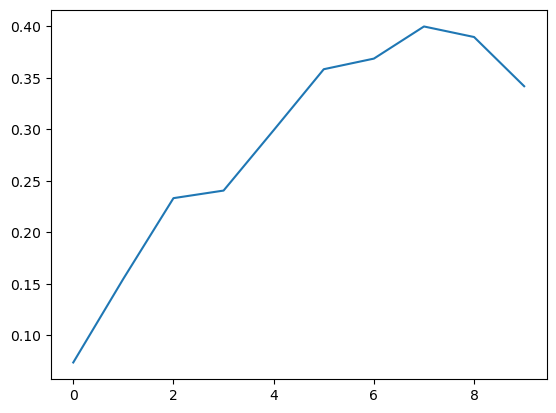

In [86]:
plt.plot([np.mean([x in cassette_exons for x in diff.loc[(diff > (i*10)) & (diff < ((i+1)*10))].index]) for i in range(10)])

In [101]:
[x in cassette_exons for x in np.random.choice((diff.loc[(diff > (i*10)) & (diff < ((i+1)*10))].index, 30))]

ValueError: setting an array element with a sequence. The requested array has an inhomogeneous shape after 1 dimensions. The detected shape was (2,) + inhomogeneous part.

In [106]:
x = []
for i in range(10):
    y = []
    for j in range(30):
        y.append(np.mean([x in cassette_exons for x in np.random.choice(list(diff.loc[(diff > (i*10)) & (diff < ((i+1)*10))].index), 50)]))
    x.append(y)

Text(0, 0.5, '% captured as\ncassette exons')

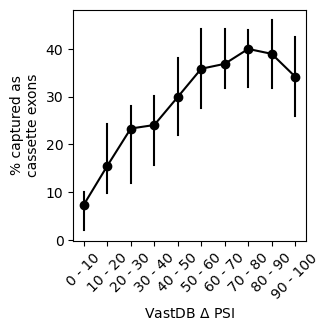

In [122]:
fig, ax = plt.subplots(figsize=(3, 3))
plt.scatter(range(10), [np.mean([x in cassette_exons for x in diff.loc[(diff > (i*10)) & (diff < ((i+1)*10))].index]) for i in range(10)], c='black')
plt.plot([np.mean([x in cassette_exons for x in diff.loc[(diff > (i*10)) & (diff < ((i+1)*10))].index]) for i in range(10)], c='black')
for i in range(10):
    plt.plot([i, i], [np.quantile(x[i], 0.1), np.quantile(x[i], 0.9)], c='black')

ax.set_xticks(range(10))
ax.set_xticklabels([f'{str(int(i*10))} - {str(int(10+i*10))}' for i in range(10)], rotation=45)
ax.set_yticks([0, 0.1, 0.2, 0.3, 0.4])
ax.set_yticklabels(['0', '10', '20', '30', '40'])
ax.set_xlabel(r'VastDB $\Delta$ PSI')
ax.set_ylabel('% captured as\ncassette exons')

In [93]:
np.random.choice((diff.loc[(diff > (i*10)) & (diff < ((i+1)*10))].index), 30)

array(['HsaEX0036734', 'HsaEX1004248', 'HsaEX0060114', 'HsaEX0036735',
       'HsaEX6035980', 'HsaEX0022489', 'HsaEX0013018', 'HsaEX0025234',
       'HsaEX0000735', 'HsaEX0032716', 'HsaEX0021054', 'HsaEX0060009',
       'HsaEX0025234', 'HsaEX0044649', 'HsaEX0021052', 'HsaEX0046413',
       'HsaEX1019704', 'HsaEX1019704', 'HsaEX0022632', 'HsaEX0022489',
       'HsaEX0036840', 'HsaEX0033960', 'HsaEX6038981', 'HsaEX0003358',
       'HsaEX0042375', 'HsaEX0037796', 'HsaEX0059076', 'HsaEX0026760',
       'HsaEX0014463', 'HsaEX7000150'], dtype=object)

(array([8286.,  876.,  550.,  335.,  212.,  210.,  158.,  125.,  103.,
         122.]),
 array([  0.,  10.,  20.,  30.,  40.,  50.,  60.,  70.,  80.,  90., 100.]),
 <BarContainer object of 10 artists>)

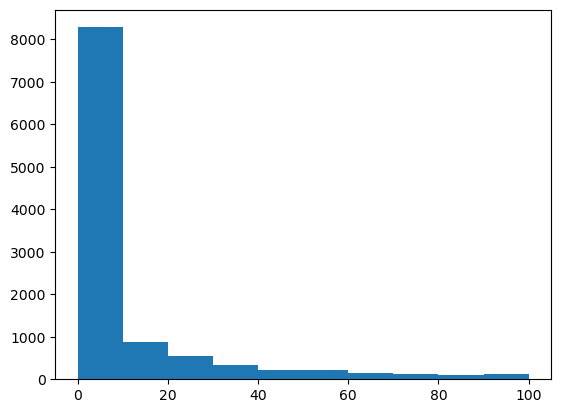

In [65]:
plt.hist(np.array(psi_table.loc[cassette_exons, columnas].max(axis=1) - psi_table.loc[cassette_exons, columnas].min(axis=1)))

(array([18415.,  1673.,   678.,   370.,   201.,   244.,   103.,    79.,
           61.,   184.]),
 array([  0.,  10.,  20.,  30.,  40.,  50.,  60.,  70.,  80.,  90., 100.]),
 <BarContainer object of 10 artists>)

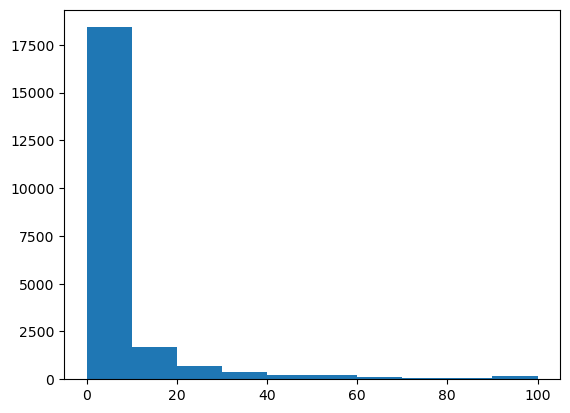

In [66]:
plt.hist(np.array(psi_table.loc[introns_only, columnas].max(axis=1) - psi_table.loc[introns_only, columnas].min(axis=1)))

(array([83252.,  3162.,  1188.,   693.,   322.,   345.,   173.,   116.,
          104.,   261.]),
 array([  0.,  10.,  20.,  30.,  40.,  50.,  60.,  70.,  80.,  90., 100.]),
 <BarContainer object of 10 artists>)

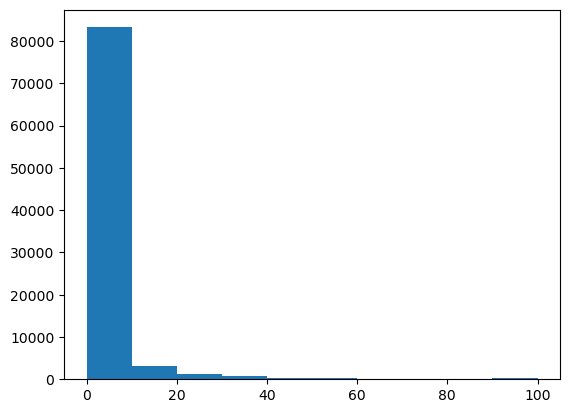

In [67]:
plt.hist(np.array(psi_table.loc[exons_only, columnas].max(axis=1) - psi_table.loc[exons_only, columnas].min(axis=1)))

In [59]:
psi_table.loc[(psi_table.loc[introns_only, columnas].max(axis=1) - psi_table.loc[introns_only, columnas].min(axis=1)).sort_values().dropna().index, columnas]

,Brain_,Heart_,Liver_,Lung_,Skin_,Blood_
HsaEX1011345,0.00,0.000,0.0,0.00,0.000,0.0
HsaEX1017752,0.00,0.000,0.0,0.00,0.000,NaN
HsaEX1017766,0.00,0.000,0.0,0.00,0.000,0.0
HsaEX1017779,0.00,0.000,0.0,0.00,0.000,0.0
HsaEX1017781,0.00,0.000,0.0,0.00,0.000,0.0
...,...,...,...,...,...,...
HsaEX6051238,7.75,100.000,0.0,62.69,38.790,NaN
HsaEX1013048,0.60,2.065,0.0,100.00,3.835,NaN
HsaEX1009764,0.00,0.000,0.0,60.00,100.000,NaN
HsaEX1012376,0.00,100.000,NaN,50.00,100.000,100.0


In [63]:
psi_table

,GENE,COORD,LENGTH,FullCO,COMPLEX,Adipose_b,Adipose_b-Q,Adipose_c,Adipose_c-Q,Adipose_d,...,Whole_Brain_b,Whole_Brain_b-Q,Zygote_a_A,Zygote_a_A-Q,Brain_,Heart_,Liver_,Lung_,Skin_,Blood_
EVENT,,,,,,,,,,,,,,,,,,,,,
HsaEX0067681,TSPAN6,chrX:100636191-100636207,17,"chrX:100636608+100636793,100636191-100636207,1...",S,3.76,"SOK,SOK,0=4=179,Bl,S@6.88,176.12",NaN,"N,N,0=0=0,Bn,S@0,0",0.00,...,0.00,"VLOW,VLOW,0=0=14,Bn,S@0.00,14.00",NaN,"N,N,0=0=0,Bn,S@0,0",8.975,1.045,0.63,2.04,0.000,0.000
HsaEX0066298,TNMD,chrX:100599016-100599182,167,"chrX:100597657,100599016-100599182,100599508",S,95.47,"SOK,SOK,169=126=7,OK,S@288.32,13.68",NaN,"N,N,0=0=0,Bn,S@0,0",91.53,...,100.00,"N,N,1=0=0,Bn,S@1.00,0.00",NaN,"N,N,0=0=0,Bn,S@0,0",100.000,100.000,100.00,100.00,99.285,NaN
HsaEX6078702,DPM1,chr20:50955186-50955285,100,"chr20:50958363,50955186-50955285,50948662",S,100.00,"SOK,SOK,252=601=0,B1,S@853.00,0.00",NaN,"N,N,0=0=0,Bn,S@0,0",100.00,...,100.00,"SOK,SOK,99=195=0,B1,S@294.00,0.00",100.00,"SOK,SOK,91=71=0,OK,S@162.00,0.00",100.000,100.000,100.00,100.00,100.000,100.000
HsaEX0056692,SCYL3,chr1:169855796-169855857,62,"chr1:169859041,169855796-169855857+169855932+1...",S,5.58,"SOK,SOK,6=5=93,OK,S@5.80,98.20",20.52,"SOK,SOK,23=30=103,OK,S@32.01,123.99",25.19,...,3.45,"VLOW,VLOW,0=1=14,Bn,S@0.52,14.48",1.37,"OK,OK,1=0=36,Bn,S@0.51,36.49",17.950,23.050,3.12,13.23,17.295,26.580
HsaEX0056690,SCYL3,chr1:169864458-169864508,51,"chr1:169866896,169864369+169864458-169864508,1...",S,90.96,"SOK,SOK,48=113=8,B1,S@153.72,15.28",96.85,"SOK,SOK,58=65=2,OK,S@121.06,3.94",96.30,...,87.50,"LOW,LOW,15=13=2,OK,S@26.25,3.75",100.00,"LOW,LOW,14=16=0,OK,S@30.00,0.00",95.240,100.000,100.00,89.19,90.110,93.320
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
HsaINT0085241,KDM5D,chrY:19708072-19708243,172,chrY:19708244-19708423=19707934-19708071:-,IR,44.34,"OK,OK,21.1=123,37=16=32,0.738@38.95,48.9",NaN,"N,N,0.0=123,0=0=0,1@NaN,NaN",NaN,...,19.66,"OK,OK,4.0=123,7=12=38,0.439@11.8,48.23",NaN,"N,N,0.0=123,0=0=0,1@NaN,NaN",16.405,12.835,6.19,10.56,19.030,3.925
HsaINT0085242,KDM5D,chrY:19707747-19707933,187,chrY:19707934-19708071=19707147-19707746:-,IR,5.39,"SOK,SOK,7.4=138,11=12=202,0.853@12.13,212.87",NaN,"N,N,0.0=138,0=0=0,1@NaN,NaN",0.00,...,6.06,"SOK,SOK,4.1=138,11=9=155,0.565@10.6,164.4",0.00,"N,N,0.0=138,0=0=3,1@0,3",3.565,4.325,0.00,0.74,2.620,0.450
HsaINT0085243,KDM5D,chrY:19706864-19707146,283,chrY:19707147-19707746=19706794-19706863:-,IR,5.16,"SOK,SOK,0.5=151,13=0=116,0.0126@6.83,125.58",NaN,"N,N,0.0=151,0=0=0,1@NaN,NaN",0.00,...,9.99,"OK,OK,2.8=151,3=5=35,0.831@4.4,39.63",NaN,"N,N,0.0=151,0=0=0,1@NaN,NaN",0.520,2.640,2.70,0.28,3.445,0.000
